# Process Data

This notebook goes through the steps to process raw .pkl files into a usable format by
1. Extracting data for each earthquake as well as earthquake metadata
2. Selecting a subset of stations out of all those with data to perform analysis
3. Compress data via subsampling


In [2]:
## Imports

import pickle
from pathlib import Path
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns; sns.set()
# matplotlib.rc('font', **{'size': 18})
import numpy as np
import json

In [3]:
load_path = '../data/Ridgecrest/'
data_dir = "../data/"
raw_path = os.path.join(data_dir, "raw")
meta_path = os.path.join(data_dir, "metadata")
relevant_path = os.path.join(data_dir, "acc", "relevant_stations")
compressed_path = os.path.join(data_dir, "acc", "compressed")
compressed_path_pool = os.path.join(data_dir, "acc", "compressed_pool")
gains_path = os.path.join(data_dir, "acc/station_gains.json")

### Step-1: Extract data for earthquakes

#### Part a: Extract accelerations

In [3]:
def get_indices(station_start_time, earthquake_start_time, period = 6000, step=100, offset=15):
    start_idx = int(100*(earthquake_start_time - station_start_time)) - offset*step
    end_idx = start_idx + period
    return (start_idx, end_idx)


In [ ]:
input_dir = Path(load_path)

output_dir = Path(raw_path)
output_files = [os.path.split(f)[1].split('.')[0] for f in sorted(output_dir.glob("*.npy"))]
print(output_files)

if not os.path.exists(raw_path):
    os.mkdir(raw_path)

def np_from_pkl(data_path, save_path, period = 6000):
    input_dir = Path(data_path)
    sorted(input_dir.glob("*.pkl"))
    for f in tqdm(sorted(input_dir.glob("*.pkl"))):
#         print(f)
        day_id = os.path.split(f)[1].split('.')[0]
#         if day_id in output_files: 
#             print("File found for date: {}".format(day_id))
#             continue
        ## Iterating over pickles
        stations = []
        with open(f, 'rb') as fp:
            try:
                data = pickle.load(fp)
            except:
                print("Pickle Corrupted")
                print("Corrupted path: {}".format(f))
                continue
            num_stations, num_events = len(data['stations']), len(data['events'])
#             data_arr = np.zeros

            for station in data['stations']:
                events = []
                for event in data['events']:
                    start_idx, end_idx = get_indices(data['stations'][station]['starttime'], event['time'])
                    if (end_idx > len(data['stations'][station]['data']) - 1) or (start_idx < 0):
                        continue #skip event
                    events.append(np.transpose(data['stations'][station]['data'][start_idx: end_idx], (1, 0)))
                events = np.array(events)
#                 print("events shape", events.shape)
                stations.append(events)
        save_arr = np.array(stations) 
#         print("station shape: ", save_arr.shape)
        filename = day_id + ".npy"
        np.save(os.path.join(save_path, filename), save_arr) 
        
np_from_pkl(load_path, raw_path)


#### Part b: Extract metadata

In [ ]:
## Reads through pickles. Saves stations and events (w/o the big boy quake data)    

if not os.path.exists(meta_path):
    os.mkdir(meta_path)
    
def save_station_and_events(data_path, save_path):
    dropped = []
    input_dir = Path(data_path)
    sorted(input_dir.glob("*.pkl"))
    for f in tqdm(sorted(input_dir.glob("*.pkl"))):
        print(f)
        day_id = os.path.split(f)[1].split('.')[0]
        ## Iterating over pickles
#         stations = []
        with open(f, 'rb') as fp:
            try:
                data = pickle.load(fp)
            except:
                print("Pickle Corrupted")
                print("Corrupted path: {}".format(f))
                continue
                
        first_stat = list(data['stations'].keys())[0]
        filename = day_id + "_meta.json"
                
        ## Idxs to keep
        idxs_to_keep = []
        for e, event in enumerate(data['events']):
            start_idx, end_idx = get_indices(data['stations'][first_stat]['starttime'], event['time'])
            if (end_idx > len(data['stations'][first_stat]['data']) - 1) or (start_idx < 0):
                ## Event was skipped
                pass
            else:
                idxs_to_keep.append(e)
        before = len(data['events'])
        data['events'] = [data['events'][idx] for idx in idxs_to_keep]
        after = len(data['events'])
        print("Num events dropped from date {}: {}".format(day_id, before - after))
        dropped.append(before - after)
        for station in data['stations']:
#             print(data['stations'][station].keys())
            for key in ['starttime', 'endtime', 'data']:
                del data['stations'][station][key]            
        for e, event in enumerate(data['events']):
            del data['events'][e]['time']
#         print(data)
        stations = np.array([stat for stat in data['stations'].keys()])
        print(stations)
        np.save(os.path.join(save_path, "{}_stations.npy".format(day_id)), stations)
        with open(os.path.join(save_path, filename), 'w') as fp:
            json.dump(data, fp)      
    with open(os.path.join(save_path, "dropped_events.txt"), 'w') as fp:
        fp.write(str(sum(dropped)) + '\n')
        for d in dropped:
            fp.write(str(d)+'\n')
        
save_station_and_events(load_path, meta_path)

#### Part c: Get shapes for all dates

In [14]:
files = [entry for entry in os.scandir(raw_path)]
print(len(files))

122


In [37]:
stations, events = [], []
for file in files:
#     print(np.load(os.path.join(data_path, file)).shape)
    temp = np.load(file)
    print(temp.shape)
    stations.append(temp.shape[0])
    events.append(temp.shape[1])
    del temp


(23, 94, 3, 6000)
(16, 3, 3, 6000)
(31, 267, 3, 6000)
(28, 250, 3, 6000)
(16, 12, 3, 6000)
(19, 1235, 3, 6000)
(31, 559, 3, 6000)
(30, 739, 3, 6000)
(33, 243, 3, 6000)
(27, 244, 3, 6000)
(16, 10, 3, 6000)
(29, 245, 3, 6000)
(16, 11, 3, 6000)
(26, 118, 3, 6000)
(31, 275, 3, 6000)
(25, 158, 3, 6000)
(16, 7, 3, 6000)
(32, 257, 3, 6000)
(29, 644, 3, 6000)
(34, 551, 3, 6000)
(16, 11, 3, 6000)
(29, 744, 3, 6000)
(31, 134, 3, 6000)
(24, 144, 3, 6000)
(26, 123, 3, 6000)
(16, 4, 3, 6000)
(32, 229, 3, 6000)
(29, 647, 3, 6000)
(27, 271, 3, 6000)
(21, 1335, 3, 6000)
(25, 99, 3, 6000)
(32, 315, 3, 6000)
(32, 836, 3, 6000)
(23, 83, 3, 6000)
(16, 2, 3, 6000)
(16, 5, 3, 6000)
(32, 731, 3, 6000)
(34, 545, 3, 6000)
(30, 251, 3, 6000)
(29, 462, 3, 6000)
(31, 357, 3, 6000)
(16, 6, 3, 6000)
(31, 233, 3, 6000)
(31, 290, 3, 6000)
(16, 15, 3, 6000)
(16, 6, 3, 6000)
(17, 1895, 3, 6000)
(16, 4, 3, 6000)
(16, 4, 3, 6000)
(31, 285, 3, 6000)
(31, 228, 3, 6000)
(24, 131, 3, 6000)
(32, 294, 3, 6000)
(16, 20, 3, 6000

In [39]:
dates = [file.name for file in files]
stat_evs = zip(stations, events)

shapes = [(s, v, 3, 6000) for s, v in stat_evs]
mapping = dict(zip(dates, shapes))
print(mapping)

with open(os.path.join(meta_path, 'date_to_shape.json'), 'w') as fp:
    json.dump(mapping, fp)

{'2019-09-22.npy': (23, 94, 3, 6000), '2019-06-12.npy': (16, 3, 3, 6000), '2019-08-25.npy': (31, 267, 3, 6000), '2019-07-31.npy': (28, 250, 3, 6000), '2019-07-02.npy': (16, 12, 3, 6000), '2019-07-07.npy': (19, 1235, 3, 6000), '2019-07-19.npy': (31, 559, 3, 6000), '2019-07-17.npy': (30, 739, 3, 6000), '2019-08-15.npy': (33, 243, 3, 6000), '2019-08-04.npy': (27, 244, 3, 6000), '2019-06-10.npy': (16, 10, 3, 6000), '2019-08-10.npy': (29, 245, 3, 6000), '2019-06-26.npy': (16, 11, 3, 6000), '2019-09-30.npy': (26, 118, 3, 6000), '2019-08-26.npy': (31, 275, 3, 6000), '2019-09-13.npy': (25, 158, 3, 6000), '2019-06-29.npy': (16, 7, 3, 6000), '2019-08-13.npy': (32, 257, 3, 6000), '2019-07-26.npy': (29, 644, 3, 6000), '2019-07-21.npy': (34, 551, 3, 6000), '2019-06-08.npy': (16, 11, 3, 6000), '2019-07-15.npy': (29, 744, 3, 6000), '2019-09-06.npy': (31, 134, 3, 6000), '2019-09-11.npy': (24, 144, 3, 6000), '2019-09-26.npy': (26, 123, 3, 6000), '2019-06-04.npy': (16, 4, 3, 6000), '2019-08-16.npy': (32

#### Part d: Count number of quakes per station

In [60]:
station_files = sorted([entry.name for entry in Path(meta_path).glob("*.npy") if "stations" in entry.name])
print(len(station_files))


122


In [61]:
stations = []
for file in station_files:
    stations.append(np.load(os.path.join(meta_path, file)))
    
print(len(stations))

122


In [70]:
date_to_shape = None
with open(os.path.join(meta_path, 'date_to_shape.json'), 'r') as json_file:
    date_to_shape = json.load(json_file)
    dates, shapes = zip(*sorted(list(date_to_shape.items())))
    dates, shapes = list(dates), list(shapes)

# dates = [dates[i].split('.')[0] for i in range(len(dates))]
print(dates)


['2019-06-01.npy', '2019-06-02.npy', '2019-06-03.npy', '2019-06-04.npy', '2019-06-05.npy', '2019-06-06.npy', '2019-06-07.npy', '2019-06-08.npy', '2019-06-09.npy', '2019-06-10.npy', '2019-06-11.npy', '2019-06-12.npy', '2019-06-13.npy', '2019-06-14.npy', '2019-06-15.npy', '2019-06-16.npy', '2019-06-17.npy', '2019-06-18.npy', '2019-06-19.npy', '2019-06-20.npy', '2019-06-21.npy', '2019-06-22.npy', '2019-06-23.npy', '2019-06-24.npy', '2019-06-25.npy', '2019-06-26.npy', '2019-06-27.npy', '2019-06-28.npy', '2019-06-29.npy', '2019-06-30.npy', '2019-07-01.npy', '2019-07-02.npy', '2019-07-03.npy', '2019-07-04.npy', '2019-07-05.npy', '2019-07-06.npy', '2019-07-07.npy', '2019-07-08.npy', '2019-07-09.npy', '2019-07-10.npy', '2019-07-11.npy', '2019-07-12.npy', '2019-07-13.npy', '2019-07-14.npy', '2019-07-15.npy', '2019-07-16.npy', '2019-07-17.npy', '2019-07-18.npy', '2019-07-19.npy', '2019-07-20.npy', '2019-07-21.npy', '2019-07-22.npy', '2019-07-23.npy', '2019-07-24.npy', '2019-07-25.npy', '2019-07-

In [71]:
 print(shapes[0], len(stations[0])) # The two MUST match

[16, 5, 3, 6000] 16


In [72]:
counts = {}
for v in stations:
    for stat in v:
        if stat not in counts:
            counts[stat] = 0
print("Before: ")
print("Stations: ", counts)
print("Number of stations: ", len(counts))

print("After:")
for s_idx, s in enumerate(shapes):
#     print(s[0])
#     print(s[0], stations[dates[s_idx]])
#     print(dates[s_idx].split('.')
#     if dates[s_idx].split('.')[0] in ['2019-09-21', '2019-09-22']: 
#         print("Skipping ", dates[s_idx].split('.')[0])
#         continue
    num_events = s[1]
#     print(s_idx)
#     print(s[0], date_to_shape[dates[s_idx]][0])
    assert s[0] == date_to_shape[dates[s_idx]][0]

#     assert s[0] == stations[s_idx].shape[0]
    for stat in stations[s_idx]:
        counts[stat] += num_events
print(counts)

Before: 
Stations:  {'CI.CCC.': 0, 'CI.CLC.': 0, 'CI.DTP.': 0, 'CI.JRC2.': 0, 'CI.LRL.': 0, 'CI.MPM.': 0, 'CI.SLA.': 0, 'CI.SRT.': 0, 'CI.TOW2.': 0, 'CI.WBM.': 0, 'CI.WCS2.': 0, 'CI.WMF.': 0, 'CI.WNM.': 0, 'CI.WRC2.': 0, 'CI.WRV2.': 0, 'CI.WVP2.': 0, 'NP.5419.': 0, 'GS.CA02.20': 0, 'ZY.SV03.': 0, 'ZY.SV05.': 0, 'GS.CA01.20': 0, 'ZY.SV07.': 0, 'GS.CA03.20': 0, 'NP.5419.10': 0, 'GS.CA04.20': 0, 'GS.CA05.20': 0, 'ZY.SV01.': 0, 'GS.CA06.20': 0, 'ZY.SV06.': 0, 'ZY.SV08.': 0, 'GS.CA07.00': 0, 'GS.CA08.00': 0, 'ZY.SV02.': 0, 'ZY.SV04.': 0, 'GS.CA09.00': 0, 'GS.CA10.00': 0}
Number of stations:  36
After:
{'CI.CCC.': 35858, 'CI.CLC.': 28201, 'CI.DTP.': 35858, 'CI.JRC2.': 35679, 'CI.LRL.': 35858, 'CI.MPM.': 35858, 'CI.SLA.': 35858, 'CI.SRT.': 35858, 'CI.TOW2.': 35858, 'CI.WBM.': 35858, 'CI.WCS2.': 35858, 'CI.WMF.': 35858, 'CI.WNM.': 35858, 'CI.WRC2.': 35858, 'CI.WRV2.': 35858, 'CI.WVP2.': 35858, 'NP.5419.': 1895, 'GS.CA02.20': 18096, 'ZY.SV03.': 21769, 'ZY.SV05.': 19676, 'GS.CA01.20': 30757, 'ZY

In [73]:
print(len([stat for stat in stations[dates.index('2019-09-22.npy')] if ('CI' in stat and 'CLC' not in stat)]))
print(len(stations[dates.index('2019-09-22.npy')]))
print(shapes[dates.index('2019-09-22.npy')])

14
23
[23, 94, 3, 6000]


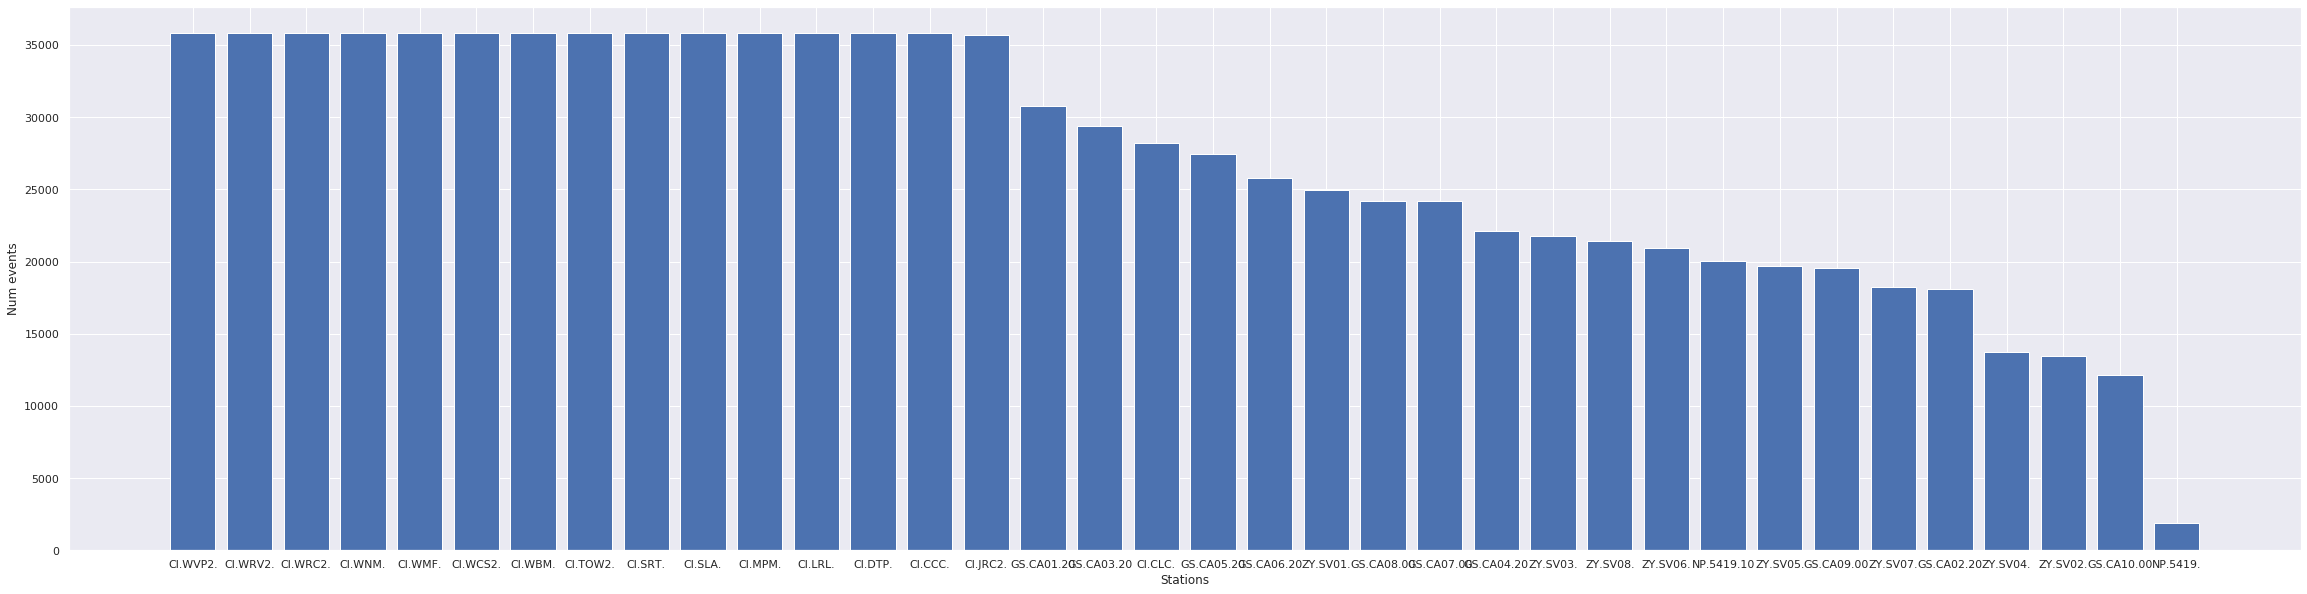

In [75]:
sorted_dict = sorted(zip(list(counts.values()), list(counts.keys())))
sorted_counts, sorted_stats = zip(*sorted_dict)
sorted_counts, sorted_stats = sorted_counts[::-1], sorted_stats[::-1]
plt.figure(figsize=(40,10))
plt.bar(sorted_stats, sorted_counts)
plt.xlabel('Stations'); plt.ylabel("Num events")
plt.show()

In [76]:
with open(os.path.join(meta_path, 'all_station_counts.json'), 'w') as fp:
    json.dump(counts, fp)  

### Step-2: Filter relevant stations

#### Part a: Load gain constants for each relevant station

In [5]:
with open(gains_path) as json_file:
    station_gains = json.load(json_file)
print(station_gains, len(station_gains))

{'CI.CCC.': [213979.0, 214322.0, 213808.0], 'CI.DTP.': [214399.0, 213971.0, 214484.0], 'CI.JRC2.': [213808.0, 213945.0, 214184.33333333334], 'CI.LRL.': [213757.0, 213671.0, 213201.0], 'CI.MPM.': [213911.0, 214219.0, 213911.0], 'CI.SLA.': [214253.0, 213671.0, 213979.0], 'CI.SRT.': [214056.0, 213628.0, 213842.0], 'CI.TOW2.': [213800.0, 214142.0, 214356.0], 'CI.WBM.': [213550.0, 214064.0, 213550.0], 'CI.WCS2.': [213757.0, 213329.0, 213415.0], 'CI.WMF.': [213842.0, 213842.0, 213842.0], 'CI.WNM.': [214030.0, 213901.5, 214030.0], 'CI.WRC2.': [214227.0, 213970.0, 214056.0], 'CI.WRV2.': [213859.0, 235198.0, 235112.0], 'CI.WVP2.': [213773.0, 213559.5, 213730.5]} 15


#### Part b: Filter the top-15 relevant stations

In [6]:
num_stations = 15

with open(os.path.join(meta_path, 'all_station_counts.json')) as json_file:
    stat_counts = json.load(json_file)

print(stat_counts)

{'CI.CCC.': 35858, 'CI.CLC.': 28201, 'CI.DTP.': 35858, 'CI.JRC2.': 35679, 'CI.LRL.': 35858, 'CI.MPM.': 35858, 'CI.SLA.': 35858, 'CI.SRT.': 35858, 'CI.TOW2.': 35858, 'CI.WBM.': 35858, 'CI.WCS2.': 35858, 'CI.WMF.': 35858, 'CI.WNM.': 35858, 'CI.WRC2.': 35858, 'CI.WRV2.': 35858, 'CI.WVP2.': 35858, 'NP.5419.': 1895, 'GS.CA02.20': 18096, 'ZY.SV03.': 21769, 'ZY.SV05.': 19676, 'GS.CA01.20': 30757, 'ZY.SV07.': 18271, 'GS.CA03.20': 29422, 'NP.5419.10': 20029, 'GS.CA04.20': 22090, 'GS.CA05.20': 27456, 'ZY.SV01.': 24989, 'GS.CA06.20': 25770, 'ZY.SV06.': 20935, 'ZY.SV08.': 21453, 'GS.CA07.00': 24203, 'GS.CA08.00': 24203, 'ZY.SV02.': 13445, 'ZY.SV04.': 13735, 'GS.CA09.00': 19583, 'GS.CA10.00': 12114}


('CI.WVP2.', 'CI.WRV2.', 'CI.WRC2.', 'CI.WNM.', 'CI.WMF.', 'CI.WCS2.', 'CI.WBM.', 'CI.TOW2.', 'CI.SRT.', 'CI.SLA.', 'CI.MPM.', 'CI.LRL.', 'CI.DTP.', 'CI.CCC.', 'CI.JRC2.')
(35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35858, 35679)


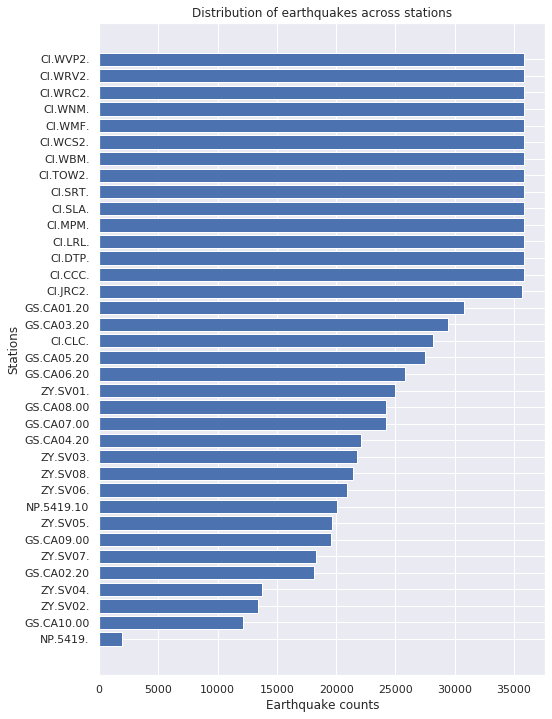

In [7]:
sorted_dict = sorted(zip(list(stat_counts.values()), list(stat_counts.keys())))
sorted_counts, sorted_stats = zip(*sorted_dict)
sorted_counts, sorted_stats = sorted_counts[::-1], sorted_stats[::-1]
# plt.bar(sorted_stats, sorted_counts)
# plt.title("Station event counts")
# plt.show()

master_stations = sorted_stats[:num_stations]
print(master_stations)
print(sorted_counts[:num_stations])

fig, ax = plt.subplots(figsize=(8,12))
# Example data
stats = sorted_stats
station_counts = sorted_counts

y_pos = np.arange(len(stats))

ax.barh(stats, station_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(stats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Earthquake counts')
ax.set_ylabel('Stations')
ax.set_title('Distribution of earthquakes across stations')

plt.show()

In [8]:
## Create array of dates
dates = sorted([entry.name.split(".")[0] for entry in list(os.scandir(raw_path)) if "npy" in entry.name])
# print(sorted(dates))
print(len(dates))

122


In [10]:
if not os.path.exists(relevant_path):
    os.mkdir(relevant_path)

print("Extracting data for stations: {}".format(master_stations))
np.save(os.path.join(relevant_path, "stations.npy"), master_stations)

dropped_dates = []
ev_count = 0
for date in tqdm(dates):

    date_data = os.path.join(raw_path, date+".npy")
#     print("Loading data from date {}".format(date))
    date_arr = np.load(date_data)
    
    ## look for stations for that day (metadata)
    station_meta = os.path.join(meta_path, date+"_stations.npy")
#     print("\tLoading metadata from {}".format(station_meta))
    date_stations = np.load(station_meta)
#     print("testing", date_stations, master_stations, date_arr)
    delete_date = False
    stats_for_date = []
#     print("\tStations for date {}: {}".format(date, date_stations))

    for master in master_stations: 
        
        if master not in date_stations: 
            delete_date = True
            print(date_stations)
            break     
#         print(date_stations, master)
        
        # Index date_arr using indices that match master in date_stations
        idx_date = date_arr[date_stations == master] #(1, num_evs, dim, time)
        print(idx_date[0, 0, :, :])

        # scale station data by gain factor for that station
        gains = np.array(station_gains[master]) #list of gain factors
        gains_mat = np.ones((1, 1, idx_date.shape[2], 1))
        gains_mat[0, 0, :, 0] = gains
        
        idx_date /= gains_mat
        print("Gain factors: ", gains, gains_mat)
        print(idx_date[0, 0, :, :])
        stats_for_date.append(idx_date)

    if delete_date is True: 
        print("\tDeleting date {}".format(date))
        dropped_dates.append(date)
        continue
    stats_for_date = np.concatenate(stats_for_date, 0)
    assert stats_for_date.shape[0] == len(master_stations)
    date_save = os.path.join(relevant_path, "{}.npy".format(date))
    stats_for_date = np.transpose(stats_for_date, [1, 0, 2, 3]) #(num_evs, stats, dim, time)
    
    stats_for_date = np.linalg.norm(stats_for_date, ord=2, axis=2)
    ev_count += stats_for_date.shape[0]
#     print(stats_for_date.shape)
    np.save(date_save, stats_for_date)
#     print(stats_for_date.shape)
#     break
print("Dropped dates: ", dropped_dates)
print(ev_count)

  1%|          | 1/122 [00:00<00:20,  6.00it/s]

Extracting data for stations: ('CI.WVP2.', 'CI.WRV2.', 'CI.WRC2.', 'CI.WNM.', 'CI.WMF.', 'CI.WCS2.', 'CI.WBM.', 'CI.TOW2.', 'CI.SRT.', 'CI.SLA.', 'CI.MPM.', 'CI.LRL.', 'CI.DTP.', 'CI.CCC.', 'CI.JRC2.')
[[ 1.33023119  2.90465999  2.13887405 ... -2.15419817 -2.49625516
  -0.45081642]
 [ 1.57159495 -0.03984293 -0.94538158 ... -1.03189659 -0.65593475
  -2.17333388]
 [-0.79992312  0.74011415  0.65914977 ... -0.16752724  0.77206218
   1.32848549]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.22263424e-06  1.35875905e-05  1.00053517e-05 ... -1.00770358e-05
  -1.16771302e-05 -2.10885576e-06]
 [ 7.35904960e-06 -1.86565961e-07 -4.42678308e-06 ... -4.83189271e-06
  -3.07143794e-06 -1.01767137e-05]
 [-3.74267183e-06  3.46283826e-06  3.08402294e-06 ... -7.83824693e-07
   3.61231636e-06  6.21570384e-06]]
[[ 2.39563084  2.98586512  1.60742998 ...  0.54033291 -0.08309218
  -0.61593449]
 [ 1.15720046  0.74377328  1.3035723  ...  0.65198952 -0.12996511
  

  2%|▏         | 2/122 [00:01<00:50,  2.36it/s]

[[ 5.47011438e-06  1.26369320e-06 -4.48586008e-06 ... -1.72962482e-06
  -4.06997580e-06 -4.94683654e-06]
 [-8.09753079e-06 -3.45314039e-06 -5.31830110e-07 ...  1.03846325e-06
   5.16300059e-06  2.13471994e-06]
 [ 3.41444874e-06  5.11959251e-06  4.35305089e-06 ... -2.70453546e-06
  -3.27191486e-06 -2.62921534e-06]]
[[ 3.93514681  1.35983276 -3.61354589 ...  5.23114538 15.27761269
  12.10410976]
 [ 1.82961512  1.04037452 -1.71736252 ... -2.48870516 -3.78166747
  -1.83767104]
 [ 3.44113636  2.28916192  0.13519599 ... -1.62156332 -1.41551852
  -0.76300621]]
Gain factors:  [213757. 213329. 213415.] [[[[213757.]
   [213329.]
   [213415.]]]]
[[ 1.84094407e-05  6.36158237e-06 -1.69049243e-05 ...  2.44723933e-05
   7.14718708e-05  5.66255597e-05]
 [ 8.57649507e-06  4.87685461e-06 -8.05030035e-06 ... -1.16660424e-05
  -1.77269263e-05 -8.61425798e-06]
 [ 1.61241542e-05  1.07263403e-05  6.33488674e-07 ... -7.59816937e-06
  -6.63270399e-06 -3.57522297e-06]]
[[  2.85825348  -1.74397254  -1.25389445 

  2%|▏         | 3/122 [00:01<00:39,  2.98it/s]

Gain factors:  [213842. 213842. 213842.] [[[[213842.]
   [213842.]
   [213842.]]]]
[[ 2.11327694e-06  1.70851462e-06  4.56917480e-06 ... -2.87971055e-06
  -1.25222978e-06  2.30669142e-06]
 [-1.61721799e-06 -2.22360010e-06  5.31495666e-07 ... -3.49523348e-07
   7.17391314e-07  4.84187270e-06]
 [-5.49477549e-06 -7.94315665e-06 -5.61320991e-06 ...  2.98260258e-06
   1.38585900e-06  8.26974777e-09]]
[[10.5352459   8.72906494  3.40213227 ...  6.71476841  5.19902277
   1.54200506]
 [-3.84583879 -4.20704126 -1.92626441 ... -1.9847368  -5.03100538
  -5.946105  ]
 [ 1.15593576  0.0554384  -0.1872309  ...  3.44262218  3.63974786
   1.68962133]]
Gain factors:  [213757. 213329. 213415.] [[[[213757.]
   [213329.]
   [213415.]]]]
[[ 4.92860860e-05  4.08363934e-05  1.59158871e-05 ...  3.14130925e-05
   2.43221170e-05  7.21382253e-06]
 [-1.80277355e-05 -1.97209065e-05 -9.02954781e-06 ... -9.30364273e-06
  -2.35833168e-05 -2.78729334e-05]
 [ 5.41637544e-06  2.59768072e-07 -8.77308999e-07 ...  1.6131116

  3%|▎         | 4/122 [00:01<00:35,  3.33it/s]

[[ 0.84303349  1.40110934 -0.67656136 ...  1.36180973  1.97475505
   1.77324581]
 [ 0.54567403  2.5088582   1.60797107 ...  0.07289056 -0.91942149
   0.31848124]
 [ 1.77497029  2.36269951  0.06525215 ... -0.38170654 -0.14227681
   0.98145652]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.94200615e-06  6.55155658e-06 -3.16358608e-06 ...  6.36779247e-06
   9.23391136e-06  8.29165858e-06]
 [ 2.32006236e-06  1.06670048e-05  6.83666984e-06 ...  3.09911499e-07
  -3.90913823e-06  1.35409841e-06]
 [ 7.54946703e-06  1.00492510e-05  2.77536441e-07 ... -1.62350937e-06
  -6.05144819e-07  4.17442120e-06]]
[[-1.23191595 -1.32724345 -0.70375478 ...  1.30300808  0.84188223
   0.20860118]
 [ 0.24072431  2.00180483  2.09656167 ...  1.57618392  1.08269048
   0.18866898]
 [-0.15005539 -0.81225801 -0.44284195 ...  0.56904936  2.25586915
  -0.02986477]]
Gain factors:  [214227. 213970. 214056.] [[[[214227.]
   [213970.]
   [214056.]]]]
[[-5.75051675e-06 -6.19550032e

  4%|▍         | 5/122 [00:01<00:40,  2.89it/s]

[[-0.39775369  0.25828123 -0.11427629 ... -0.41898629 -0.93454367
  -2.28693008]
 [-0.24103948  1.47238708  2.21763277 ... -0.58631361 -1.37852192
  -0.64918023]
 [-2.58502293 -1.52788413  1.22856021 ... -0.63672662 -0.27085048
   0.04422821]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.86063575e-06  1.20820324e-06 -5.34568397e-07 ... -1.95995888e-06
  -4.37166372e-06 -1.06979370e-05]
 [-1.12867601e-06  6.89450516e-06  1.03841448e-05 ... -2.74543444e-06
  -6.45497821e-06 -3.03980967e-06]
 [-1.20947779e-05 -7.14864807e-06  5.74817450e-06 ... -2.97910976e-06
  -1.26725236e-06  2.06934468e-07]]
[[ 2.52640581  0.75820976  0.85920614 ... -0.58182722  1.64966536
   1.68398678]
 [-0.60154581  0.14797322 -0.13900544 ... -0.19066201 -0.62736446
  -1.68141723]
 [ 1.23452902  0.38758874 -1.48525691 ... -0.36369863  0.49114195
   1.9058497 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.18134182e-05  3.545

  5%|▍         | 6/122 [00:02<00:46,  2.50it/s]

[[-0.30066451 -0.16140121 -0.72807884 ...  0.12003008 -0.63259238
   1.27960014]
 [-0.04426243  2.33338428  3.63305116 ...  0.77022111  1.36703467
   1.16559064]
 [ 0.44688502  1.79577494  0.15396507 ... -0.04325117  0.21205868
   1.57975352]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.40646627e-06 -7.55012149e-07 -3.40585033e-06 ...  5.61483795e-07
  -2.95917810e-06  5.98578933e-06]
 [-2.07260420e-07  1.09261554e-05  1.70118920e-05 ...  3.60658793e-06
   6.40118877e-06  5.45791990e-06]
 [ 2.09088090e-06  8.40205276e-06  7.20370143e-07 ... -2.02363107e-07
   9.92177898e-07  7.39133403e-06]]
[[ 0.36099079 -0.21456356 -0.93381482 ...  0.68771809  0.31702584
   0.45790529]
 [-0.3266823  -1.42735791 -0.73127747 ...  0.57738292  0.61672789
   1.55819225]
 [-0.18150917 -1.55281115 -0.39500594 ...  3.32380009  2.85378814
   2.87861538]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.68798504e-06 -1.003

  6%|▌         | 7/122 [00:02<00:42,  2.74it/s]

[[-2.02690792 -0.82627171 -1.64115787 ...  1.21966946  2.54468656
   0.40952799]
 [ 1.98056233  0.66215611 -3.92405343 ... -1.03463042 -0.62914121
   0.87595594]
 [ 0.66330832 -1.08228672 -0.47694492 ... -1.25167561 -1.60687757
  -1.89030421]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-9.48158991e-06 -3.86518275e-06 -7.67710546e-06 ...  5.70544204e-06
   1.19036855e-05  1.91571427e-06]
 [ 9.27405397e-06  3.10056965e-06 -1.83745206e-05 ... -4.84469395e-06
  -2.94597623e-06  4.10169503e-06]
 [ 3.10347995e-06 -5.06379162e-06 -2.23152486e-06 ... -5.85632657e-06
  -7.51824174e-06 -8.84433531e-06]]
[[ 1.31256759e+00  1.19322145e+00  2.00105882e+00 ...  1.69323564e+00
   1.55050778e+00  2.52470762e-01]
 [-3.16518456e-01  3.60774010e-01  2.36821473e-01 ...  2.47686672e+00
   2.73646670e-03 -4.87424582e-01]
 [ 4.37005162e-01  2.11073303e+00  3.04828191e+00 ...  2.94261575e+00
   3.00638676e+00  1.41185212e+00]]
Gain factors:  [213859. 235198. 235

  7%|▋         | 8/122 [00:03<00:42,  2.71it/s]

[[-0.25726154 -0.14306322 -0.50013489 ...  0.54428542  3.32331014
   3.34042692]
 [ 0.29629683 -0.19928244 -0.84617949 ...  1.36518145  0.49733496
   2.05714798]
 [ 1.25069296  3.12503481  0.29944226 ...  1.68820965 -1.55923581
  -1.30112195]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.20343329e-06 -6.69229591e-07 -2.33956059e-06 ...  2.54609056e-06
   1.55459770e-05  1.56260469e-05]
 [ 1.38742053e-06 -9.33147144e-07 -3.96226572e-06 ...  6.39251097e-06
   2.32878873e-06  9.63266902e-06]
 [ 5.85172899e-06  1.46213798e-05  1.40102728e-06 ...  7.89877745e-06
  -7.29533600e-06 -6.08767560e-06]]
[[ 0.38314578 -0.58431065 -0.01638195 ... -2.18974376  0.4372032
   2.42809534]
 [ 0.62222981  0.19002885 -1.79576218 ...  1.23490405  1.67982697
   0.19095181]
 [ 1.69020677  1.67066753  1.17380607 ... -4.34369135 -1.5253334
   2.2707603 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.79158127e-06 -2.73222

  7%|▋         | 9/122 [00:03<00:34,  3.28it/s]

[[ 3.98708105  3.62535381  2.1202817  ... -0.34718731 -1.02170777
   0.48985288]
 [ 0.70249236  0.63653243  0.80376559 ... -0.7102837   0.59395027
   0.31312227]
 [-0.93804526 -1.57333338 -1.17608786 ... -2.15008974 -1.39495039
  -0.50724167]]
Gain factors:  [214227. 213970. 214056.] [[[[214227.]
   [213970.]
   [214056.]]]]
[[ 1.86114778e-05  1.69229547e-05  9.89735979e-06 ... -1.62065151e-06
  -4.76927639e-06  2.28660662e-06]
 [ 3.28313481e-06  2.97486763e-06  3.75644060e-06 ... -3.31954805e-06
   2.77585770e-06  1.46339334e-06]
 [-4.38224233e-06 -7.35010176e-06 -5.49429989e-06 ... -1.00445198e-05
  -6.51675445e-06 -2.36966806e-06]]
[[-0.10224546 -1.01516986 -1.77880168 ...  1.54505432 -0.10998723
  -1.05621254]
 [ 1.03939247 -1.02087164 -0.68665612 ... -1.82077813 -0.79184324
   1.24487698]
 [ 1.02975619  1.07395923  0.17430478 ...  1.95986009 -0.29209954
  -1.51346648]]
Gain factors:  [214030.  213901.5 214030. ] [[[[214030. ]
   [213901.5]
   [214030. ]]]]
[[-4.77715542e-07 -4.743

  8%|▊         | 10/122 [00:03<00:45,  2.47it/s]

[[-0.29484159  2.40084291  3.05105519 ...  1.29201734  0.17659779
  -1.00358641]
 [-1.47132039 -1.29721332 -1.13340139 ...  1.35092425  0.20895258
  -0.07309541]
 [-0.59943867 -0.99254596  0.52535391 ...  2.3575418   0.61388034
  -0.18225369]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.37922744e-06  1.12308051e-05  1.42724067e-05 ...  6.04387524e-06
   8.26099596e-07 -4.69463595e-06]
 [-6.88951037e-06 -6.07424777e-06 -5.30719258e-06 ...  6.32575115e-06
   9.78427913e-07 -3.42271878e-07]
 [-2.80464729e-06 -4.64391354e-06  2.45802030e-06 ...  1.10304416e-05
   2.87221682e-06 -8.52726628e-07]]
[[ 1.02301049 -0.74811804 -2.24252558 ... -0.90807194 -2.22619462
  -0.55786926]
 [ 0.23525083 -0.28498498  0.19942631 ...  2.66009617  3.20681
   0.40315807]
 [ 0.65052187  0.45296288 -0.41559908 ... -0.01140356 -0.91005474
  -0.50785154]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 4.78357466e-06 -3.498183

 10%|▉         | 12/122 [00:04<00:39,  2.77it/s]

[[-0.30159968  0.4801538   0.22000675 ...  1.21070099  4.45692158
   3.46608949]
 [ 1.70925689  1.19842041  1.89942074 ...  0.51041967  4.40787077
   5.81837082]
 [-0.15956336 -0.4532443   0.45105076 ... -1.72755194 -1.94027591
  -1.86672533]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.41084085e-06  2.24609188e-06  1.02916060e-06 ...  5.66348879e-06
   2.08488517e-05  1.62138787e-05]
 [ 8.00365653e-06  5.61164643e-06  8.89410557e-06 ...  2.39005835e-06
   2.06400126e-05  2.72447295e-05]
 [-7.46563371e-07 -2.12063462e-06  2.11037151e-06 ... -8.08285171e-06
  -9.07814237e-06 -8.73401468e-06]]
[[ 0.62951595 -1.08358443 -0.68025732 ... -0.88883746  0.18675131
   0.1756669 ]
 [-0.65652037 -1.00422001  0.32435533 ... -1.77395964 -0.97314924
  -0.73762351]
 [ 1.02873278  2.42372417  2.43380761 ...  3.43090606  3.35797453
   0.95015448]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 2.94360278e-06 -5.066

 11%|█▏        | 14/122 [00:06<01:25,  1.26it/s]

[[ 1.41605282 -0.25402546 -1.67340946 ... -1.65066803 -2.08764243
  -0.58912617]
 [ 3.56146193  2.70143914 -0.13692816 ...  1.44060087 -1.61147285
  -3.26281285]
 [-1.15275908 -1.12364745 -0.61961162 ...  3.72527575  1.49759233
  -2.02891612]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.62409574e-06 -1.18829534e-06 -7.82797389e-06 ... -7.72159265e-06
  -9.76569740e-06 -2.75584929e-06]
 [ 1.66766729e-05  1.26495854e-05 -6.41170990e-07 ...  6.74566513e-06
  -7.54577926e-06 -1.52782379e-05]
 [-5.39351695e-06 -5.25730980e-06 -2.89903229e-06 ...  1.74297808e-05
   7.00691913e-06 -9.49287126e-06]]
[[-1.14797986 -1.38453662  0.04715651 ... -0.21539034  0.4550184
   0.09430094]
 [ 0.12251005 -0.48684999 -2.15529251 ...  0.81868511  0.2535769
   0.23201449]
 [-0.24161153 -0.2030616   0.0615862  ...  1.37592185  1.76299477
   1.15332842]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-5.36792866e-06 -6.47406

 13%|█▎        | 16/122 [00:08<01:13,  1.44it/s]

[[-3.75406075 -0.39923149 -0.53736287 ... -1.03871608 -2.78577304
  -4.92682934]
 [ 1.73163712  0.58971494 -1.53677213 ... -1.96677816 -3.52325869
  -2.48571444]
 [-1.29768014 -2.41875339 -2.19643545 ...  6.08841228  3.05696177
  -2.77637649]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.75609677e-05 -1.86754872e-06 -2.51370787e-06 ... -4.85896759e-06
  -1.30314541e-05 -2.30470141e-05]
 [ 8.10845277e-06  2.76136133e-06 -7.19599049e-06 ... -9.20950910e-06
  -1.64977849e-05 -1.16394468e-05]
 [-6.07157209e-06 -1.13168377e-05 -1.02766589e-05 ...  2.84863989e-05
   1.43028804e-05 -1.29900809e-05]]
[[ 0.97669977 -0.31059656 -0.70544928 ...  4.15400171  3.2284286
   0.79838288]
 [-1.36079979 -0.97041959 -0.39911637 ...  4.77798367  5.2624712
   1.45262182]
 [-0.04828024 -0.04518916 -0.27274492 ...  3.30661702 -0.11519253
  -5.55800676]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 4.56702673e-06 -1.45234

 14%|█▍        | 17/122 [00:08<00:59,  1.77it/s]

[[ 0.82541817  0.49244148  0.89600128 ... -2.71613288 -0.20522742
   0.31813484]
 [ 0.61975712  2.01781559  2.2508235  ... -2.83414865 -1.20507145
  -0.72655469]
 [ 0.09794492 -0.4151524  -0.38507229 ...  1.48626518 -1.0830723
  -0.71761388]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 3.86119002e-06  2.30357190e-06  4.19136785e-06 ... -1.27056872e-05
  -9.60024979e-07  1.48819002e-06]
 [ 2.90203487e-06  9.44849370e-06  1.05395616e-05 ... -1.32710024e-05
  -5.64279018e-06 -3.40211834e-06]
 [ 4.58263632e-07 -1.94241066e-06 -1.80167216e-06 ...  6.95392180e-06
  -5.06746723e-06 -3.35756420e-06]]
[[-0.59892666  0.66397399  1.03812087 ...  2.37140179  1.36245966
  -0.43108904]
 [-0.81838274  0.40306118  0.51092494 ...  0.55943602 -1.6184423
  -0.91500801]
 [-2.57521129 -2.46863461 -2.34983778 ...  0.82058549  2.42441225
   3.52851319]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-2.80056796e-06  3.10472

 15%|█▍        | 18/122 [00:08<00:59,  1.75it/s]

[[ 0.17008913 -5.41492605 -5.47990322 ...  5.17598724 -2.34569287
  -5.24710846]
 [-3.93014097 -1.8935858  -0.36978206 ... -0.48129359  0.56144667
   0.98221773]
 [ 1.27278149  0.57641023 -1.86636496 ... -2.10429144  0.01859723
   2.50831771]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 7.95652985e-07 -2.53302618e-05 -2.56342158e-05 ...  2.42125397e-05
  -1.09728210e-05 -2.45452347e-05]
 [-1.84030257e-05 -8.86678327e-06 -1.73151773e-06 ... -2.25367445e-06
   2.62899411e-06  4.59926966e-06]
 [ 5.95507656e-06  2.69690210e-06 -8.73232859e-06 ... -9.84553650e-06
   8.70125417e-08  1.17358903e-05]]
[[-2.01732945 -2.33125949 -0.96164775 ... -0.332104   -1.44524133
  -1.22012234]
 [ 0.17034636  0.83480108  0.46684733 ...  0.99506211 -0.33627754
  -1.69356143]
 [-2.44246793 -2.10688496  0.50653303 ...  0.96805137  1.97304702
  -0.65351486]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-9.43298834e-06 -1.090

 16%|█▌        | 19/122 [00:10<01:31,  1.12it/s]

[[ 0.61916852 -0.48807684 -2.1149745  ...  0.4849748  -0.87031353
  -2.93631506]
 [ 0.26190668  2.49625874  1.82539845 ...  1.73051226  1.67619944
   0.2258171 ]
 [-0.01925911  0.35381204  2.5020206  ...  0.47518679  0.71284705
   0.67977208]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.89638317e-06 -2.28315473e-06 -9.89355297e-06 ...  2.26864385e-06
  -4.07120415e-06 -1.37356685e-05]
 [ 1.22638742e-06  1.16888208e-05  8.54749353e-06 ...  8.10318558e-06
   7.84886384e-06  1.05739665e-06]
 [-9.01093291e-08  1.65541202e-06  1.17064275e-05 ...  2.22329894e-06
   3.33526125e-06  3.18051040e-06]]
[[ 1.89469779  0.9650231   1.31745112 ... -0.81362218 -0.02711556
  -0.0511994 ]
 [ 0.42841703 -1.35472608 -2.39398432 ...  0.74501663  0.70658803
   0.43813166]
 [-2.09264874 -0.12815464  0.62156844 ...  1.15653563  2.58545995
   0.77009982]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 8.85956535e-06  4.512

 16%|█▋        | 20/122 [00:11<01:20,  1.27it/s]

[[ 0.99183363  2.64179921 -0.83061486 ...  0.45379278  2.38495612
   0.99549693]
 [-3.93426728 -2.42969632  1.40905571 ...  0.98490149 -2.89984179
  -3.85687184]
 [ 3.7186482   0.84313679 -5.29254341 ...  1.5467881  -1.50697136
  -2.93037653]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 4.63965808e-06  1.23579648e-05 -3.88549941e-06 ...  2.12277874e-06
   1.11564890e-05  4.65679449e-06]
 [-1.84223473e-05 -1.13771400e-05  6.59795378e-06 ...  4.61183646e-06
  -1.35786129e-05 -1.80599404e-05]
 [ 1.73987718e-05  3.94485947e-06 -2.47626961e-05 ...  7.23709577e-06
  -7.05080164e-06 -1.37106147e-05]]
[[-3.25638741e-01 -1.39272308e+00 -1.12782693e+00 ... -2.25647017e-01
  -8.24082017e-01 -6.38451099e-01]
 [ 2.97045648e-01 -6.59650564e-01 -1.69318521e+00 ...  3.62277269e+00
  -1.02288579e-03 -2.38894463e+00]
 [ 1.05762231e+00  3.67642045e-01 -1.37547195e+00 ... -9.69047368e-01
  -4.51408923e-01 -1.26326717e-02]]
Gain factors:  [213859. 235198. 235

 17%|█▋        | 21/122 [00:12<01:30,  1.11it/s]

[[ 4.47394705  0.34373805 -3.85771513 ...  3.53881001 -1.54393375
  -5.61362553]
 [-1.25543976 -0.04946775  2.13192368 ...  4.0727849  -2.05162477
  -2.15628839]
 [-3.2248919  -1.36590731  0.4598434  ...  3.46409965  0.57804054
  -3.03376412]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.09284945e-05  1.60795820e-06 -1.80458483e-05 ...  1.65540551e-05
  -7.22230473e-06 -2.62597500e-05]
 [-5.87864159e-06 -2.31634509e-07  9.98280889e-06 ...  1.90709610e-05
  -9.60680642e-06 -1.00968975e-05]
 [-1.50885901e-05 -6.39079266e-06  2.15151042e-06 ...  1.62077927e-05
   2.70452996e-06 -1.41943435e-05]]
[[ 1.71115148  3.27156281  3.18110013 ... -1.71514595  1.57989335
   2.51734805]
 [ 1.66307628  2.79887462  2.11392903 ... -0.55170649 -1.13873744
  -0.23977332]
 [-0.75104642 -1.02570736 -1.24193335 ... -0.37200963 -0.31515828
  -0.4903405 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 8.00130685e-06  1.529

 19%|█▉        | 23/122 [00:12<00:51,  1.92it/s]

[[ -6.80942345  -8.06023121   2.26712251 ...   2.60499883   1.7980535
   -3.51269484]
 [  2.97193837   8.99424076  -3.049999   ... -10.74193478   9.25883007
    6.54675722]
 [ 10.03303528  10.39872265   4.8202281  ...   5.93385267   0.64962536
   -4.53382206]]
Gain factors:  [213757. 213671. 213201.] [[[[213757.]
   [213671.]
   [213201.]]]]
[[-3.18559086e-05 -3.77074492e-05  1.06060738e-05 ...  1.21867299e-05
   8.41167074e-06 -1.64331219e-05]
 [ 1.39089459e-05  4.20938769e-05 -1.42742768e-05 ... -5.02732461e-05
   4.33321792e-05  3.06394280e-05]
 [ 4.70590442e-05  4.87742677e-05  2.26088438e-05 ...  2.78321991e-05
   3.04700898e-06 -2.12654821e-05]]
[[-0.3814458  -0.25029156  1.01838005 ... -1.45388293 -1.98248172
  -0.56568515]
 [-0.35787684 -1.70531511 -0.52411306 ...  0.02465999 -0.97741395
  -0.20736797]
 [-0.7221067  -1.2622155  -0.3201676  ... -0.54763484 -0.75574595
  -0.69622922]]
Gain factors:  [214399. 213971. 214484.] [[[[214399.]
   [213971.]
   [214484.]]]]
[[-1.77913981

 20%|█▉        | 24/122 [00:12<00:43,  2.24it/s]

[[ 3.29890919  3.25855803  0.18962574 ... -6.09460878 -1.68285918
   3.46566343]
 [-0.54193902  0.36457357  1.59575963 ... -0.18058261  1.01826406
  -2.12199879]
 [ 1.57533205  0.6708169   0.81653702 ... -0.03346257 -1.460109
  -2.8833425 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.54318328e-05  1.52430758e-05  8.87042517e-07 ... -2.85097219e-05
  -7.87217835e-06  1.62118857e-05]
 [-2.53764885e-06  1.70712878e-06  7.47220157e-06 ... -8.45584546e-07
   4.76805787e-06 -9.93633525e-06]
 [ 7.37064689e-06  3.13861100e-06  3.82040477e-06 ... -1.56564331e-07
  -6.83154251e-06 -1.34905524e-05]]
[[-0.68714243  0.21668342 -1.78901935 ... -2.7254796  -2.6168592
  -1.80352843]
 [-0.80965161 -0.65668088 -0.51785111 ...  0.66640633  0.33874562
   1.20965755]
 [ 1.69232881  1.43876863  0.51312488 ...  0.41588143 -1.05393219
  -1.36610031]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.21306296e-06  1.013206

 20%|██        | 25/122 [00:13<00:37,  2.60it/s]

[[ 0.62405455  1.94073987  1.6537832  ...  1.44462061  0.09291241
   0.55674917]
 [-1.14996815 -1.2708689  -0.43835035 ... -0.26744407 -0.50413996
   1.60146987]
 [-0.08385884  0.4241398   0.6206767  ... -0.47849187 -1.00960541
  -0.29140833]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.91923934e-06  9.07850790e-06  7.73616501e-06 ...  6.75773184e-06
   4.34631154e-07  2.60439422e-06]
 [-5.38476700e-06 -5.95088908e-06 -2.05259120e-06 ... -1.25231645e-06
  -2.36065340e-06  7.49893999e-06]
 [-3.92357853e-07  1.98446079e-06  2.90401555e-06 ... -2.23876271e-06
  -4.72373109e-06 -1.36343821e-06]]
[[-1.06681061  0.53401339  0.27548534 ...  0.48283312 -0.14324173
   0.71568573]
 [-0.15904762 -0.18247561  0.9495827  ...  1.06921351 -1.18322778
  -1.23935986]
 [ 0.67284077  1.06357145  0.23121874 ... -1.06379676 -1.41797304
  -0.32165423]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-4.98838304e-06  2.497

 21%|██▏       | 26/122 [00:13<00:45,  2.13it/s]

[[-0.94329357 -0.08943041  0.17594731 ... -0.0097089   0.32272792
   1.06652212]
 [ 2.75964093  2.16154408  0.7081905  ...  0.29528603  0.27616644
   1.63919771]
 [ 0.79241508  0.75175631 -0.21073742 ... -0.84471029 -0.84804004
   1.69881701]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-4.41259453e-06 -4.18342888e-07  8.23056740e-07 ... -4.54168544e-08
   1.50967577e-06  4.98904034e-06]
 [ 1.29221174e-05  1.01215075e-05  3.31612736e-06 ...  1.38268740e-06
   1.29315923e-06  7.67560192e-06]
 [ 3.70754330e-06  3.51730946e-06 -9.85996019e-07 ... -3.95222156e-06
  -3.96780078e-06  7.94840706e-06]]
[[-0.28573823 -0.84229082 -0.14991948 ... -0.00276978  0.67003095
   0.30888635]
 [ 0.24841785  0.68438512  0.5859313  ...  0.99234074  0.64604795
  -0.11514136]
 [-1.0385102   0.03664492  1.63799953 ... -0.4489221  -1.27928019
  -0.58408558]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.33610570e-06 -3.938

 22%|██▏       | 27/122 [00:14<00:47,  2.01it/s]

[[ 1.58377874  2.69819808  1.07586336 ... -0.87054443 -0.10838602
   0.76757461]
 [ 1.01478243 -0.38602144 -2.72637534 ...  1.37816072  1.15013218
   0.01961657]
 [ 1.53606641 -0.35867777 -1.50447607 ...  0.87880731  0.7842297
   1.61704087]]
Gain factors:  [214030.  213901.5 214030. ] [[[[214030. ]
   [213901.5]
   [214030. ]]]]
[[ 7.39979787e-06  1.26066350e-05  5.02669421e-06 ... -4.06739445e-06
  -5.06405725e-07  3.58629448e-06]
 [ 4.74415761e-06 -1.80466914e-06 -1.27459384e-05 ...  6.44296891e-06
   5.37692433e-06  9.17084106e-08]
 [ 7.17687433e-06 -1.67582944e-06 -7.02927660e-06 ...  4.10600059e-06
   3.66411109e-06  7.55520662e-06]]
[[ 0.86364847  0.00961036  0.43424392 ... -0.15173544  0.38901356
   0.3849445 ]
 [-0.28012335 -0.16814356 -0.2985656  ...  1.29266441  1.13935983
   0.9957549 ]
 [ 0.18129742  0.24854586  0.53711867 ... -1.08732283 -0.92288983
   0.1499254 ]]
Gain factors:  [213842. 213842. 213842.] [[[[213842.]
   [213842.]
   [213842.]]]]
[[ 4.03872239e-06  4.4941

 23%|██▎       | 28/122 [00:14<00:47,  1.99it/s]

[[-1.10144579  1.38129377  0.24744397 ... -1.56836736 -2.45020175
  -1.55348563]
 [-3.03320789  0.29984942  1.51990592 ...  1.29633296  0.72230446
   0.46009421]
 [-1.28381777 -1.79654729 -0.59797108 ...  0.12337113 -1.63596904
  -3.11500239]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.15240837e-06  6.46149782e-06  1.15750808e-06 ... -7.33660173e-06
  -1.14616989e-05 -7.26698709e-06]
 [-1.42031045e-05  1.40405564e-06  7.11701388e-06 ...  6.07012545e-06
   3.38221649e-06  2.15440762e-06]
 [-6.00671298e-06 -8.40566645e-06 -2.79778076e-06 ...  5.77227545e-07
  -7.65435463e-06 -1.45744402e-05]]


 24%|██▍       | 29/122 [00:15<00:50,  1.85it/s]

[[-0.79513347 -1.64629662 -1.4301734  ... -0.87912846 -1.02665186
  -1.60271955]
 [-1.03365445 -1.6099273  -0.46708897 ... -0.34996581 -1.94840944
  -2.59043622]
 [-1.57467651 -0.12028649  1.34839058 ... -1.21109796 -2.66157389
  -2.24658728]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.71802670e-06 -7.69804694e-06 -6.68745948e-06 ... -4.11078541e-06
  -4.80060161e-06 -7.49428149e-06]
 [-4.39482671e-06 -6.84498719e-06 -1.98593937e-06 ... -1.48796253e-06
  -8.28412418e-06 -1.10138531e-05]
 [-6.69755909e-06 -5.11613559e-07  5.73509893e-06 ... -5.15115330e-06
  -1.13204510e-05 -9.55539180e-06]]
[[ 1.07996237  1.11550653  0.43829256 ...  0.51690406  0.89922249
   0.28946248]
 [ 0.03679497 -0.00871923 -0.27994975 ...  0.30086377  0.46255964
   1.05346215]
 [ 1.14059579 -0.64286786 -0.5366351  ...  0.7369628   0.15594761
  -0.33921608]]
Gain factors:  [214227. 213970. 214056.] [[[[214227.]
   [213970.]
   [214056.]]]]
[[ 5.04120570e-06  5.20712389e

 25%|██▍       | 30/122 [00:15<00:48,  1.89it/s]

[[ 9.90755081e-01 -6.04059458e-01 -5.69335163e-01 ...  1.37214983e+00
  -4.71907288e-01 -8.79087567e-01]
 [-3.71346354e-01 -7.95144022e-01  6.95663869e-01 ...  6.81630909e-01
  -1.06311965e+00  1.13549130e-03]
 [ 8.75891268e-01  1.67674363e+00  4.91730779e-01 ...  1.91544521e+00
  -2.60059953e-01 -7.23269701e-01]]
Gain factors:  [214030.  213901.5 214030. ] [[[[214030. ]
   [213901.5]
   [214030. ]]]]
[[ 4.62904771e-06 -2.82231210e-06 -2.66007178e-06 ...  6.41101633e-06
  -2.20486515e-06 -4.10731004e-06]
 [-1.73606241e-06 -3.71733729e-06  3.25226270e-06 ...  3.18665792e-06
  -4.97013649e-06  5.30847750e-09]
 [ 4.09237615e-06  7.83415235e-06  2.29748530e-06 ...  8.94942395e-06
  -1.21506309e-06 -3.37929123e-06]]
[[ 0.25817665  1.08400476  0.38675994 ...  0.45713905  0.63364351
  -0.14603387]
 [-0.25152251 -0.40747941  0.15858796 ... -0.1010792   0.59059894
  -0.21207125]
 [ 0.64508909  0.45749742 -0.40174693 ... -0.70328265  0.35958785
   1.71816385]]
Gain factors:  [213842. 213842. 213

 25%|██▌       | 31/122 [00:16<00:51,  1.77it/s]

[[ 1.38940692 -2.91026807 -0.76188028 ... -1.78712463  2.40010333
   0.39740968]
 [ 2.45853806  2.44368339  2.63387036 ... -0.94251359  2.45649815
   3.00959373]
 [-1.18400848  2.2860229   1.05939066 ...  2.76720023  1.92306721
  -1.13115156]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.49944997e-06 -1.36138243e-05 -3.56396869e-06 ... -8.35991745e-06
   1.12273455e-05  1.85902653e-06]
 [ 1.15121924e-05  1.14426349e-05  1.23331922e-05 ... -4.41335359e-06
   1.15026405e-05  1.40925303e-05]
 [-5.53972633e-06  1.06958197e-05  4.95666582e-06 ...  1.29471471e-05
   8.99762651e-06 -5.29241993e-06]]
[[-3.43212318 -2.21217465 -2.06646323 ...  1.16898859  1.56234109
   2.11158657]
 [ 0.70286041 -0.2978906  -1.83298767 ... -1.22719502 -0.70404488
   0.44757921]
 [-0.94931912 -0.51317775 -0.59482116 ...  1.61537933  0.18110828
  -0.35003024]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.60485328e-05 -1.034

 27%|██▋       | 33/122 [00:17<00:46,  1.92it/s]

[[ 4.17091894  2.15292311 -0.51064521 ...  1.29136264  3.00430989
  -1.33390188]
 [ 1.63510561  0.21415001 -1.91704309 ...  1.36221421  1.39061308
  -1.1359905 ]
 [-4.1297636  -2.33225584  1.52659988 ...  1.62266695  1.83319914
   2.44876838]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.95109716e-05  1.00710712e-05 -2.38872641e-06 ...  6.04081265e-06
   1.40537387e-05 -6.23980522e-06]
 [ 7.65644052e-06  1.00276509e-06 -8.97662286e-06 ...  6.37861677e-06
   6.51159550e-06 -5.31931616e-06]
 [-1.93222942e-05 -1.09121339e-05  7.14263937e-06 ...  7.59211697e-06
   8.57715274e-06  1.14572716e-05]]
[[ 0.48635966  0.27647144 -0.1437317  ... -0.88784713  1.36601031
   0.49819145]
 [ 0.94601202  1.66529489  1.33035195 ... -0.80786616 -0.9121955
  -0.52903861]
 [-0.20481466 -0.60897022 -0.94238675 ... -0.60913205  1.39465797
   3.07992196]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 2.27420710e-06  1.2927

 28%|██▊       | 34/122 [00:34<07:58,  5.44s/it]

[[ 4.49827337  3.80604076  2.24620676 ...  6.76906872  3.19936061
   1.28017139]
 [-2.37968874 -0.1866565   1.21450484 ... -2.44040847 -3.4917829
  -2.49920368]
 [ 1.44526374  1.98874319  1.72606039 ... -1.0196594   1.21619701
   0.33708194]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.10422896e-05  1.78041229e-05  1.05074390e-05 ...  3.16647505e-05
   1.49661585e-05  5.98846157e-06]
 [-1.11429777e-05 -8.74025763e-07  5.68696236e-06 ... -1.14273000e-05
  -1.63503984e-05 -1.17026107e-05]
 [ 6.76208470e-06  9.30491056e-06  8.07587308e-06 ... -4.77077160e-06
   5.69032971e-06  1.57713541e-06]]
[[ 0.39443085 -0.62419754  1.05028558 ...  1.06032157  1.79742146
   1.01769924]
 [ 0.06889547 -0.88138592 -0.98755044 ... -0.82975525 -2.19173884
  -4.01570797]
 [-0.39241818 -0.78337634 -1.33442473 ... -1.86249089 -1.5454545
   0.12681222]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.84435000e-06 -2.91873

 29%|██▊       | 35/122 [01:18<24:39, 17.01s/it]

[[-0.24929509 -2.39704275 -1.89200795 ...  1.25717747  0.98350447
  -1.33990037]
 [-0.41677243 -0.33876124 -0.26723561 ... -1.88008654 -3.02781773
  -3.96505952]
 [-0.36248434 -0.75358039 -1.07433784 ...  1.39662409  0.27929857
  -0.44153956]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.16616732e-06 -1.12130285e-05 -8.85054683e-06 ...  5.88089923e-06
   4.60069548e-06 -6.26786533e-06]
 [-1.95155179e-06 -1.58626163e-06 -1.25134029e-06 ... -8.80357250e-06
  -1.41778648e-05 -1.85665331e-05]
 [-1.69598787e-06 -3.52584395e-06 -5.02660051e-06 ...  6.53450999e-06
   1.30677921e-06 -2.06587060e-06]]
[[ 0.28923312  0.4798632  -0.05579063 ...  2.01465631  1.40906525
   1.10388196]
 [-0.60942709 -0.95278156 -0.30979878 ... -2.13209701 -2.42904592
  -0.57308924]
 [ 0.14536171 -0.78744411 -0.18470892 ...  0.06335711  0.37152931
  -0.74887031]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.35244773e-06  2.243

 30%|██▉       | 36/122 [02:31<48:16, 33.68s/it]

[[-11.1841383   -7.88195992   1.23930776 ... -21.50352669  -2.80015039
   11.73858261]
 [  2.10548401   5.36211586  -1.85169148 ...   9.43033504  15.28288269
    7.16449022]
 [ -4.32189131   0.74173671   2.72497988 ...   2.28755212  10.16823673
   -2.39155054]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.23178245e-05 -3.68706989e-05  5.79730724e-06 ... -1.00590471e-04
  -1.30987094e-05  5.49114369e-05]
 [ 9.85900421e-06  2.51082994e-05 -8.67061163e-06 ...  4.41578813e-05
   7.15626450e-05  3.35479818e-05]
 [-2.02212193e-05  3.47042986e-06  1.27496070e-05 ...  1.07029746e-05
   4.75750383e-05 -1.11895613e-05]]
[[-1.57727456 -1.73974884  0.9095     ...  1.26020503  5.28909445
   0.58280838]
 [-0.47950083 -1.59507072 -2.06336856 ... -2.52247477 -2.39953685
   3.49082685]
 [ 4.3010807  -2.05498481 -5.57839584 ... -3.88279629  3.11371851
   3.94261384]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-7.3

 30%|███       | 37/122 [03:20<54:26, 38.43s/it]

[[ 1.44604421 -2.35773492 -1.64583552 ... -2.23556471 -1.42297459
   1.13763416]
 [ 2.87761521  1.95282555  2.0623312  ... -2.50760365 -2.64977217
   0.71380872]
 [ 0.81737453  0.4514426   0.59635597 ...  2.00469303  4.75329208
   1.73012459]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.76439123e-06 -1.10291520e-05 -7.69898686e-06 ... -1.04576570e-05
  -6.65647480e-06  5.32169244e-06]
 [ 1.34745362e-05  9.14417549e-06  9.65693963e-06 ... -1.17419438e-05
  -1.24076530e-05  3.34243485e-06]
 [ 3.82432328e-06  2.11220485e-06  2.79022402e-06 ...  9.37953653e-06
   2.22396527e-05  8.09488862e-06]]
[[ 0.86547822  2.85894966  0.60096741 ...  0.5553121  -0.13320562
  -1.17123294]
 [-0.82059926 -0.96009564 -1.06834388 ... -1.50269103 -0.51753289
  -0.13452311]
 [-0.87893075 -0.98869282  0.77151495 ... -2.03470016 -1.48507643
  -1.22976708]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 4.04695719e-06  1.336

 31%|███       | 38/122 [04:18<1:01:55, 44.23s/it]

[[-11.32910061  -3.59322143   8.56706524 ...  -6.86494684  -2.15354633
   -1.81354296]
 [-11.98830986  -2.55533433   4.56942701 ...  -9.13879776   1.57142484
   -0.40897775]
 [ -4.31498957   1.00630844  -0.01670276 ...  -1.14579821   1.85926664
   -1.13887382]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.29959378e-05 -1.68085840e-05  4.00755252e-05 ... -3.21132549e-05
  -1.00739866e-05 -8.48349867e-06]
 [-5.61356899e-05 -1.19654444e-05  2.13965055e-05 ... -4.27927475e-05
   7.35825305e-06 -1.91505293e-06]
 [-2.01889275e-05  4.70830526e-06 -7.81487141e-08 ... -5.36094851e-06
   8.69911706e-06 -5.32855075e-06]]
[[ 5.80698872  5.86064196  2.146878   ... -0.01442527 -1.01567662
  -4.61935329]
 [ 4.08045197  8.79646111 -1.1434871  ...  0.6975674   4.34489965
   1.86075711]
 [-2.94493198 -0.51085746 -1.19447863 ... -3.50349045 -3.03078318
  -1.6712997 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 2.7

 32%|███▏      | 39/122 [05:46<1:19:20, 57.36s/it]

[[ 11.82361031  -2.37161517 -18.78375435 ...   0.79686201   1.48634648
    1.36439002]
 [ 19.77411842  30.20146561  24.86234283 ...   2.85810256   1.55917513
    2.05120468]
 [ -4.75617886 -17.83853149 -11.67975807 ...  -0.71577537  -2.25831962
   -1.23733342]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.53091845e-05 -1.10940819e-05 -8.78677586e-05 ...  3.72760829e-06
   6.95291961e-06  6.38242442e-06]
 [ 9.25930170e-05  1.41419443e-04  1.16418810e-04 ...  1.33831675e-05
   7.30089335e-06  9.60483931e-06]
 [-2.22531593e-05 -8.34627322e-05 -5.46471284e-05 ... -3.34896222e-06
  -1.05662019e-05 -5.78922249e-06]]
[[ 6.88886547 14.63768291 15.06059074 ... -0.05864291  1.82118702
   0.86341405]
 [ 9.68178082  8.89198017  3.73234296 ... -0.59039646  2.02449656
   1.45333648]
 [-7.16425037 -9.98029709 -3.26137686 ... -0.28734207  1.23867452
   2.29098868]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.2

 33%|███▎      | 40/122 [07:21<1:33:39, 68.53s/it]

[[ 3.34696007 -0.77885669  2.18234587 ... -4.20926476 -1.63714778
   1.49223042]
 [ 2.25497055 -2.79348135 -6.12676048 ... -0.5893423   5.04066896
   6.0695138 ]
 [-3.22185564 -2.80272198  3.11127639 ... -0.64850074 -3.42886138
  -2.06675196]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.56566080e-05 -3.64338197e-06  1.02087067e-05 ... -1.96903480e-05
  -7.65834686e-06  6.98044381e-06]
 [ 1.05589803e-05 -1.30805764e-05 -2.86887752e-05 ... -2.75961639e-06
   2.36031128e-05  2.84207155e-05]
 [-1.50743841e-05 -1.31133459e-05  1.45570070e-05 ... -3.03419840e-06
  -1.60429203e-05 -9.66989717e-06]]
[[ 2.67881656  3.16941261  2.62396836 ...  1.36777115 -3.60309577
   0.50798386]
 [ 3.29085445  1.72483611 -2.39703155 ... -0.33802673 -1.19564438
  -0.06643443]
 [ 4.73105478 -0.65373409 -2.45122528 ... -2.06897092 -1.77946365
   3.09549379]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.25260875e-05  1.482

 34%|███▎      | 41/122 [08:45<1:38:50, 73.22s/it]

[[ 1.10172665  0.2299436   0.17812543 ...  0.54686064  1.39770365
   0.72229975]
 [ 1.17009854  2.40025425  0.19019771 ...  0.71269703  2.19349933
  -0.95533955]
 [ 0.73250151 -2.26577997 -4.55603456 ...  1.98186707  0.82644051
  -1.08333826]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.15372218e-06  1.07564381e-06  8.33245668e-07 ...  2.55813707e-06
   6.53826090e-06  3.37881657e-06]
 [ 5.47902830e-06  1.12392764e-05  8.90607565e-07 ...  3.33722934e-06
   1.02711391e-05 -4.47341163e-06]
 [ 3.42722029e-06 -1.06011073e-05 -2.13167263e-05 ...  9.27273868e-06
   3.86674112e-06 -5.06871158e-06]]
[[-1.51916265 -3.12112641 -4.20970345 ...  1.16731715  0.16508977
  -1.61608911]
 [-0.59024817 -0.2675156   1.39178526 ... -0.90834987 -0.11243197
  -1.73896468]
 [ 0.23921432  0.01397135  0.74502361 ... -1.89286423  1.66556275
   3.2857337 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-7.10357130e-06 -1.459

 34%|███▍      | 42/122 [10:21<1:46:49, 80.12s/it]

[[ -2.79367304  -5.33940601 -12.96932602 ...  -0.31301376  -3.07819152
    3.82421112]
 [ -6.85791969  -6.77462673  -1.09050763 ...  -3.31765819  -5.56773329
   -0.03596929]
 [  1.14893746   3.61049533  -8.17084694 ...   5.41351795  -0.06480054
   -3.79533863]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.30684092e-05 -2.49769897e-05 -6.06686814e-05 ... -1.46423432e-06
  -1.43993466e-05  1.78891213e-05]
 [-3.21124543e-05 -3.17224321e-05 -5.10634098e-06 ... -1.55350532e-05
  -2.60711103e-05 -1.68427474e-07]
 [ 5.37563644e-06  1.68927473e-05 -3.82296721e-05 ...  2.53287105e-05
  -3.03188072e-07 -1.77575902e-05]]
[[ 9.70481205  0.73390245 -3.20897293 ...  3.41993093  1.96797168
  -3.8970027 ]
 [ 3.44467735 -2.65266371  0.49507222 ...  1.78135335  4.26116753
  -1.98041773]
 [-5.36804581  1.80672753 -2.2649529  ... -2.9399209   2.02363038
  -0.24320002]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 4.5

 35%|███▌      | 43/122 [11:13<1:34:15, 71.59s/it]

[[-7.00248575 -5.65740061  2.23763323 ... -7.19847584 -5.63608503
  -1.93302798]
 [-2.75865722 -1.05516362 -1.66380835 ...  0.77405995 -3.24707866
  -4.77439404]
 [ 0.71931887 -1.16352868  0.47997299 ... -2.02487206 -0.5249716
   0.52514642]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.27566426e-05 -2.64645236e-05  1.04673332e-05 ... -3.36734566e-05
  -2.63648124e-05 -9.04243278e-06]
 [-1.29175111e-05 -4.94084141e-06 -7.79084211e-06 ...  3.62456342e-06
  -1.52045620e-05 -2.23562709e-05]
 [ 3.36554150e-06 -5.44390567e-06  2.24569254e-06 ... -9.47394997e-06
  -2.45623158e-06  2.45704953e-06]]
[[ 1.31678343  0.68735713  2.44618034 ... -0.13177475 -0.07746363
   0.89277458]
 [ 0.96965754 -0.31633374 -0.47973701 ...  0.29443902  0.23870766
  -1.19460034]
 [-0.23515548 -1.26095736  1.57219934 ... -0.98955965  0.77099669
   2.25470161]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 6.15725047e-06  3.2140

 36%|███▌      | 44/122 [12:01<1:23:51, 64.51s/it]

[[-4.43832588  2.67506027 -3.29741716 ... -2.44951367 -7.73464012
  -6.59870768]
 [-1.71647179  5.04847145 -5.85190487 ...  6.93534517 -4.42600441
  -3.88762236]
 [-2.3913219   1.66506946  2.32185555 ...  4.07161045  8.90023422
  -5.54421997]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.07618637e-05  1.25135554e-05 -1.54248533e-05 ... -1.14584801e-05
  -3.61815576e-05 -3.08678256e-05]
 [-8.03744058e-06  2.36396482e-05 -2.74017539e-05 ...  3.24750019e-05
  -2.07249240e-05 -1.82039308e-05]
 [-1.11884916e-05  7.79050936e-06  1.08634731e-05 ...  1.90502079e-05
   4.16423216e-05 -2.59402377e-05]]
[[-3.48933339  0.72084361 -1.24301887 ... -3.02454352 -1.64791381
   3.22416615]
 [ 0.82479149  0.70874906 -2.16285348 ... -1.70043159 -2.46350265
  -0.32144511]
 [ 4.05562258 -0.26607442 -0.24761145 ...  0.51249343 -1.50346076
   4.16829252]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.63160465e-05  3.370

 37%|███▋      | 45/122 [12:44<1:14:42, 58.21s/it]

[[-0.17140807 -0.53684872 -0.60785687 ... -3.2514534  -2.52728343
  -0.26688328]
 [ 0.05139555  1.06055713  0.98616618 ...  1.47222006  0.09380382
  -1.07655787]
 [ 2.34012198  0.62197286 -1.99326396 ... -1.36539245  0.47908053
  -0.03327703]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-8.01822831e-07 -2.51130276e-06 -2.84346887e-06 ... -1.52098413e-05
  -1.18222761e-05 -1.24844243e-06]
 [ 2.40661521e-07  4.96609669e-06  4.61775842e-06 ...  6.89372312e-06
   4.39239723e-07 -5.04102077e-06]
 [ 1.09489380e-05  2.91008003e-06 -9.32606231e-06 ... -6.38838372e-06
   2.24151690e-06 -1.55696220e-07]]
[[-0.24605295  0.14381781 -0.68390393 ... -1.47302365 -1.71944034
  -1.21446049]
 [-1.24349904  1.00373542  0.13336995 ...  0.56564349  0.9739005
   1.77056158]
 [-1.45550001 -0.32200062 -2.57825994 ... -2.16620874 -0.23432468
   1.40788507]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.15053821e-06  6.7248

 38%|███▊      | 46/122 [13:23<1:06:22, 52.41s/it]

[[ -0.64165324  -0.54658884   1.38226593 ...   3.00024128  -8.64959908
  -11.98206902]
 [ -1.94676173  -0.68815511   1.77248383 ...  25.45064163  15.00251484
   -0.28150463]
 [  0.3831324   -2.06787014  -3.20565009 ...  31.32702065  36.8830986
    5.20915747]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.00156353e-06 -2.55686564e-06  6.46604541e-06 ...  1.40347063e-05
  -4.04616068e-05 -5.60504321e-05]
 [-9.11578144e-06 -3.22231095e-06  8.29971893e-06 ...  1.19173540e-04
   7.02498125e-05 -1.31815551e-06]
 [ 1.79259581e-06 -9.67512891e-06 -1.49985617e-05 ...  1.46572532e-04
   1.72568251e-04  2.43725508e-05]]
[[ -1.22041738  -1.77405107  -1.30115724 ... -13.76858521  -7.74049473
   -1.14365745]
 [ -0.2444368    0.28750426  -0.41557115 ...  13.59331036  -3.74530649
   -9.43324661]
 [ -1.9881556   -0.99174583   0.09710778 ...   9.26433849  11.35736179
    8.38200474]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [2

 39%|███▊      | 47/122 [14:07<1:02:28, 49.99s/it]

[[ 1.87580633  1.37851644 -0.671381   ... -0.73428112 -1.77486277
  -0.10204513]
 [ 0.03818404 -0.45673326  0.74078619 ... -1.74278486 -0.28949007
   1.17873633]
 [ 0.31751186 -0.90667939 -2.39509296 ... -0.5732193  -0.27185538
   1.13692141]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 8.77475795e-06  6.44850582e-06 -3.14062579e-06 ... -3.43486372e-06
  -8.30255816e-06 -4.77352735e-07]
 [ 1.78798113e-07 -2.13866982e-06  3.46875786e-06 ... -8.16065245e-06
  -1.35554763e-06  5.51947504e-06]
 [ 1.48557111e-06 -4.24216194e-06 -1.12061356e-05 ... -2.68197239e-06
  -1.27195409e-06  5.31941583e-06]]
[[-2.83263946 -2.6706171  -0.6574924  ...  0.91605318  2.08928084
   0.52304125]
 [-0.59159398 -0.73123109 -1.76200175 ... -0.28249371 -1.59189761
  -1.07177746]
 [ 2.34795523  1.65946996 -0.33408257 ... -2.59920979 -0.47686884
   2.02398491]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.32453601e-05 -1.248

 39%|███▉      | 48/122 [14:45<56:54, 46.15s/it]  

[[ 4.12918043 -0.42779624 -4.97904062 ...  3.74637771  0.16585305
  -2.6457839 ]
 [ 1.80293787 -0.77713168 -1.34628737 ...  2.02879238  1.30656135
  -0.93848789]
 [-0.13878144  0.16497311 -0.95821244 ...  0.35677183  0.43322384
   0.25599793]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.93157248e-05 -2.00117061e-06 -2.32912511e-05 ...  1.75250275e-05
   7.75837235e-07 -1.23766046e-05]
 [ 8.44232106e-06 -3.63894688e-06 -6.30403878e-06 ...  9.49989292e-06
   6.11802027e-06 -4.39450311e-06]
 [-6.49329147e-07  7.71874440e-07 -4.48327419e-06 ...  1.66926024e-06
   2.02696313e-06  1.19776039e-06]]
[[ 0.39171243 -0.61376792 -0.30983657 ... -2.30386662 -1.85204577
  -1.67870486]
 [-0.97405761 -0.54815352 -0.17812294 ... -1.4800868  -0.90022701
  -0.38991693]
 [-0.5151673  -0.17828727 -0.80849117 ...  4.31332493  4.0519309
   2.62412882]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.83163873e-06 -2.8699

 40%|████      | 49/122 [15:16<50:53, 41.83s/it]

[[ 3.68484306 -1.6680944  -7.34790373 ... -0.76144445  0.0669264
   2.61189342]
 [-0.43482479 -3.63059783 -2.15181017 ...  0.44724283  1.21402872
   0.93315721]
 [ 4.67552471 11.61487389  7.22470093 ... -2.98083711 -2.56503654
  -0.33636609]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.72371771e-05 -7.80311076e-06 -3.43724592e-05 ... -3.56192994e-06
   3.13072300e-07  1.22180697e-05]
 [-2.03608266e-06 -1.70004042e-05 -1.00759281e-05 ...  2.09423054e-06
   5.68473290e-06  4.36954200e-06]
 [ 2.18757955e-05  5.43435489e-05  3.38028542e-05 ... -1.39467091e-05
  -1.20012658e-05 -1.57378609e-06]]
[[-0.19959578 -0.1548797   1.49735796 ...  0.81988639  0.53229368
   0.97517401]
 [ 0.39364278 -0.68774742 -0.67906725 ...  0.02327758  0.89860594
  -0.21567631]
 [-0.75139689 -0.10872331  1.59272408 ...  2.22850847  1.67590189
  -0.88586235]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-9.33305492e-07 -7.2421

 41%|████      | 50/122 [15:53<48:13, 40.19s/it]

[[ 3.64420342  2.77316833  3.3847506  ...  2.51677918 -0.24515364
  -3.05128622]
 [-0.29299948 -1.44860744 -1.26238549 ...  1.51578152  0.76002085
  -1.04531121]
 [-0.63574475 -1.46587038 -2.15359259 ...  0.81865513 -0.09534514
   1.20930588]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.70470706e-05  1.29724910e-05  1.58333868e-05 ...  1.17731387e-05
  -1.14679420e-06 -1.42734874e-05]
 [-1.37198053e-06 -6.78315619e-06 -5.91116521e-06 ...  7.09770121e-06
   3.55882483e-06 -4.89470715e-06]
 [-2.97451581e-06 -6.85849881e-06 -1.00762062e-05 ...  3.83031497e-06
  -4.46099829e-07  5.65808756e-06]]
[[ 2.0327611   0.76820356 -0.08713786 ... -1.45155394 -3.30613041
  -1.61419082]
 [ 0.7361111  -0.11246208  0.31613004 ... -2.5020225  -0.27825633
   1.84303808]
 [ 0.29013762 -0.01940865 -0.28335533 ...  0.16769575 -0.78043312
   0.26593971]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 9.50514637e-06  3.592

 42%|████▏     | 51/122 [16:29<46:20, 39.16s/it]

[[ 0.79202116  0.69953251 -0.0770959  ...  1.37086499  0.89966148
   0.71629256]
 [ 0.91702622  0.04417317 -0.23800723 ...  0.44149855  0.75460517
   0.54644179]
 [-0.9074555  -1.90533185 -1.57562017 ... -0.05817527 -1.9476943
  -2.37683702]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 3.70496347e-06  3.27231460e-06 -3.60643748e-07 ...  6.41271343e-06
   4.20848976e-06  3.35071576e-06]
 [ 4.29400809e-06  2.06842431e-07 -1.11447738e-06 ...  2.06733275e-06
   3.53346573e-06  2.55873325e-06]
 [-4.24579320e-06 -8.91464648e-06 -7.37199499e-06 ... -2.72189852e-07
  -9.11285147e-06 -1.11207199e-05]]
[[-0.93345052 -0.04921728  1.16347361 ...  1.17984807  1.35648537
   1.72314358]
 [ 1.24014342  1.74436402  1.46005917 ... -0.22279736  0.06981064
   0.7814306 ]
 [-2.36579156 -1.24029231  0.88693362 ...  0.13947199  1.38891733
   1.51365876]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-4.36479419e-06 -2.3013

 43%|████▎     | 52/122 [17:06<44:42, 38.33s/it]

[[-6.35742009e-01  9.36256722e-02  2.48632506e-01 ...  2.67758226e+00
   1.36271632e+00 -1.61158419e+00]
 [ 2.76083398e+00  1.90591061e+00  1.61816597e+00 ... -2.29099298e+00
  -3.06882858e+00 -2.82725878e-03]
 [-1.79349494e+00 -1.76249373e+00 -1.25271451e+00 ...  3.02274942e+00
   2.80012816e-01 -2.74081016e+00]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.97391162e-06  4.37967714e-07  1.16306786e-06 ...  1.25253529e-05
   6.37459509e-06 -7.53876395e-06]
 [ 1.29277039e-05  8.92449463e-06  7.57712005e-06 ... -1.07276566e-05
  -1.43698996e-05 -1.32387404e-08]
 [-8.39138513e-06 -8.24633700e-06 -5.86118741e-06 ...  1.41428080e-05
   1.31012100e-06 -1.28236735e-05]]
[[ 0.89078224 -0.23201184 -0.95491612 ...  2.14014888  2.76042295
   0.94757485]
 [-1.177423   -0.80362463 -1.85762084 ...  1.41552198  2.20128131
   0.99978399]
 [ 1.88694346  2.54403329  2.83876157 ...  0.55617738  0.2060031
  -1.01586473]]
Gain factors:  [213859. 235198. 2351

 43%|████▎     | 53/122 [17:37<41:42, 36.27s/it]

[[ 2.04517007  5.76348066  6.31632376 ...  1.04265869 -0.01138263
   0.01574328]
 [ 1.20984948  2.86951208  2.62729335 ... -1.35977924 -2.77279019
  -0.94274586]
 [ 0.3818996  -0.36354116 -0.76056039 ...  1.56621051 -1.04690003
  -2.10169721]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 9.56701767e-06  2.69607512e-05  2.95468734e-05 ...  4.87741056e-06
  -5.32463325e-08  7.36448642e-08]
 [ 5.66516346e-06  1.34365930e-05  1.23023951e-05 ... -6.36721494e-06
  -1.29836893e-05 -4.41444124e-06]
 [ 1.78682778e-06 -1.70093251e-06 -3.55850191e-06 ...  7.32796914e-06
  -4.89822479e-06 -9.83339863e-06]]
[[ 0.85362309  1.29831719  1.20368969 ... -0.68935996  1.4943552
   1.25671315]
 [ 2.36689806  1.54623067  1.28975976 ...  1.62669384  1.9960202
   2.73903704]
 [ 3.09205985  2.42245913  2.05572772 ... -0.74709886 -2.04496408
  -1.0489831 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.99152288e-06  6.07090

 44%|████▍     | 54/122 [18:08<39:08, 34.53s/it]

[[-1.48698282 -2.34600806 -0.970613   ...  4.47976875  0.82200396
  -2.29164481]
 [-1.38893759 -3.32574534 -1.0143491  ... -0.04542392  1.93061221
   4.05053663]
 [-1.24135602  0.36029294 -0.58767533 ... -1.00626862  1.44642639
   2.35766506]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-6.95589631e-06 -1.09742955e-05 -4.54039099e-06 ...  2.09557276e-05
   3.84521881e-06 -1.07199918e-05]
 [-6.50374997e-06 -1.55729216e-05 -4.74972597e-06 ... -2.12699136e-07
   9.04016073e-06  1.89667827e-05]
 [-5.80804338e-06  1.68573480e-06 -2.74960912e-06 ... -4.70811897e-06
   6.76752448e-06  1.10310183e-05]]
[[-0.39391717  0.60353875  0.75120533 ...  2.55787849  1.29103947
  -0.02960651]
 [-3.22283316 -1.65016854  0.85492271 ... -1.19117391 -1.08396578
   0.16953342]
 [ 0.0752051   1.43152499  0.03234254 ... -0.44992006 -0.75193495
   0.15667279]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.84194807e-06  2.822

 45%|████▌     | 55/122 [18:35<36:11, 32.40s/it]

[[-0.04838937  1.33349335  1.33567977 ...  1.52341306  0.38747603
   1.72017705]
 [-0.32803896 -0.30320302  0.64159453 ... -0.90932953 -0.34070539
  -0.08692066]
 [ 1.5355159  -0.67074627 -1.61930633 ... -0.9175635  -2.87573075
  -1.9673568 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.26358650e-07  6.23789418e-06  6.24812193e-06 ...  7.12631185e-06
   1.81255831e-06  8.04674610e-06]
 [-1.53605417e-06 -1.41975897e-06  3.00428934e-06 ... -4.25796808e-06
  -1.59536520e-06 -4.07009118e-07]
 [ 7.18435555e-06 -3.13828053e-06 -7.57639329e-06 ... -4.29308638e-06
  -1.34549386e-05 -9.20484817e-06]]
[[-3.54352832e-01  1.70157909e-01  6.13106847e-01 ...  2.28946447e+00
   2.52829599e+00  1.09227931e+00]
 [ 1.53506353e-01 -1.04291093e+00 -8.94634306e-01 ...  2.49194717e+00
   1.29520206e-03 -1.88498294e+00]
 [-8.85663748e-01 -6.07219040e-01  9.22078714e-02 ...  1.33130145e+00
   1.59601045e+00  6.50311708e-01]]
Gain factors:  [213859. 235198. 235

 46%|████▌     | 56/122 [19:09<36:08, 32.85s/it]

[[-0.59687054 -2.47730875 -3.12844729 ...  5.67941236  1.95285559
  -4.46403408]
 [ 1.09323525 -0.97181493 -1.56339157 ...  1.4228307  -1.68037057
  -5.67926693]
 [ 1.24727118  0.70259815  1.38619828 ...  0.16997436  3.05313587
   1.32428718]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.79207637e-06 -1.15885016e-05 -1.46344360e-05 ...  2.65674915e-05
   9.13518352e-06 -2.08821230e-05]
 [ 5.11911319e-06 -4.55055818e-06 -7.32063695e-06 ...  6.66245567e-06
  -7.86839531e-06 -2.65933706e-05]
 [ 5.83571919e-06  3.28730880e-06  6.48572984e-06 ...  7.95274221e-07
   1.42849798e-05  6.19606082e-06]]
[[-0.88507652 -0.89402354 -2.96925807 ... -1.23278868 -1.75770688
  -2.64315081]
 [ 0.68602151  2.82235813  3.45409346 ... -2.28180361  0.93159235
   2.71878219]
 [-0.04491555 -2.40025401 -2.98900104 ...  2.06146979  2.45623565
   0.6872018 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-4.13859844e-06 -4.180

 47%|████▋     | 57/122 [19:31<31:54, 29.46s/it]

[[ 2.46919417  3.09440327  2.89790177 ... -0.31351739  0.11296538
   0.93095934]
 [ 1.47404015  1.23481011 -0.3668555  ...  0.83689499  2.45949888
   2.89007664]
 [ 1.37195659  3.08868122  1.51616967 ...  0.10151916 -1.57526231
   0.7050336 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.15505427e-05  1.44751829e-05  1.35559765e-05 ... -1.46659022e-06
   5.28436157e-07  4.35489675e-06]
 [ 6.90224575e-06  5.78204254e-06 -1.71781401e-06 ...  3.91879073e-06
   1.15166915e-05  1.35328873e-05]
 [ 6.41909595e-06  1.44512890e-05  7.09383858e-06 ...  4.74986771e-07
  -7.37032061e-06  3.29870374e-06]]
[[ 0.31525511 -0.22226438 -0.67644572 ... -0.80685228  0.70284098
  -1.47896409]
 [ 0.74033254 -2.00819039 -1.32605851 ...  1.02705395  0.60385615
  -0.68754095]
 [ 1.90403676 -0.3993907  -0.04414781 ...  0.21682177  1.54506207
   1.72998285]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.47412597e-06 -1.039

 48%|████▊     | 58/122 [20:04<32:43, 30.68s/it]

[[-1.82748818  0.04963512  2.10141897 ...  2.70945668  1.35235453
   1.79512906]
 [ 0.9416126   2.71924257  0.97192073 ... -2.78894067  0.73083872
   4.40257025]
 [-1.18280542 -0.95537078  0.40322664 ... -2.21247745 -6.71273851
  -6.98912144]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-8.54873246e-06  2.32186085e-07  9.83014212e-06 ...  1.26744569e-05
   6.32612410e-06  8.39736104e-06]
 [ 4.40913470e-06  1.27329506e-05  4.55105359e-06 ... -1.30593145e-05
   3.42217844e-06  2.06151927e-05]
 [-5.53409747e-06 -4.46997871e-06  1.88661255e-06 ... -1.03517160e-05
  -3.14074899e-05 -3.27006274e-05]]
[[ 0.77246314  0.1742142  -0.10658904 ...  2.32805252  0.45638922
  -1.59292829]
 [ 0.41910383 -1.64506602 -1.52922368 ...  1.45422292  2.64677739
   1.32279527]
 [ 2.79518318  1.68411672  1.40852749 ...  1.38787723  3.89604521
   1.36462164]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.61202074e-06  8.146

 48%|████▊     | 59/122 [20:26<29:17, 27.89s/it]

[[ 1.16104066  2.11657047  0.3670449  ...  0.476693   -0.76503587
  -0.65843344]
 [ 2.90081978  2.17583442  0.14866564 ...  1.79699385  0.63553864
   2.63575554]
 [-0.43319538  0.01716769 -0.29467416 ... -0.33189464  2.33057475
  -0.04502118]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.43118478e-06  9.90101871e-06  1.71698435e-06 ...  2.22990277e-06
  -3.57873009e-06 -3.08005893e-06]
 [ 1.35831924e-05  1.01884225e-05  6.96132164e-07 ...  8.41448801e-06
   2.97593241e-06  1.23420196e-05]
 [-2.02682997e-06  8.03240115e-08 -1.37871833e-06 ... -1.55286511e-06
   1.09042685e-05 -2.10644638e-07]]
[[-2.7527318  -2.46088529  0.35644647 ...  0.07657029  0.30883503
  -0.18879929]
 [ 1.03103507 -0.08248315 -1.72010672 ... -1.27047467 -1.99564707
  -2.58394027]
 [-0.64686841  0.56345028  2.05366731 ... -2.85510588 -1.28094602
   0.99138552]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.28717136e-05 -1.150

 49%|████▉     | 60/122 [20:47<26:52, 26.01s/it]

[[-2.06484985 -3.40882397  1.71003449 ... -7.70068455 -1.17541099
   5.5319252 ]
 [ 2.18451738 -3.03546524 -4.8949852  ...  0.0468282   1.41188061
   3.24100113]
 [-2.6617012  -0.32671317  3.50505519 ... -1.1116215  -1.61489975
   0.74369085]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-9.65907693e-06 -1.59459986e-05  7.99930061e-06 ... -3.60227182e-05
  -5.49840712e-06  2.58775673e-05]
 [ 1.02290808e-05 -1.42136746e-05 -2.29209433e-05 ...  2.19274718e-07
   6.61118149e-06  1.51761038e-05]
 [-1.24535394e-05 -1.52862214e-06  1.63994151e-05 ... -5.20104290e-06
  -7.55577587e-06  3.47957287e-06]]
[[ 0.03028743 -1.16773248 -1.01916635 ... -0.97058493 -1.31095803
  -1.35428953]
 [-0.58075476 -1.37722182 -1.80263925 ...  0.53626299  0.960513
   1.08089912]
 [ 0.61376619 -0.22697242 -1.17017305 ...  0.32838792 -0.23020157
  -0.01235513]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.41623358e-07 -5.46029

 50%|█████     | 61/122 [21:02<23:09, 22.78s/it]

[[ 4.01391888 -2.14571834 -5.27414179 ... -1.4304347   2.33409882
   4.81229067]
 [ 2.29507899  1.03279495 -0.05146754 ...  8.21518707  6.41569185
   3.89186978]
 [ 1.272048   -5.09920502 -5.84236956 ... -2.08493447  0.47236848
  -3.81415224]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.87765474e-05 -1.00373683e-05 -2.46716928e-05 ... -6.69137217e-06
   1.09185857e-05  2.25112183e-05]
 [ 1.07467895e-05  4.83609932e-06 -2.40998605e-07 ...  3.84679074e-05
   3.00417067e-05  1.82238195e-05]
 [ 5.95164470e-06 -2.38581064e-05 -2.73352168e-05 ... -9.75496933e-06
   2.21011264e-06 -1.78456151e-05]]
[[ 0.59469146  2.06501055  1.44086337 ... -0.16580878  1.20803034
   2.12635779]
 [ 0.09441441 -2.13139153 -1.92751241 ... -1.98735249 -1.61143601
   0.34274626]
 [-2.74254251 -1.64894354  0.22181943 ... -0.16828907 -1.74507236
  -1.90794432]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 2.78076422e-06  9.655

 51%|█████     | 62/122 [21:11<18:34, 18.57s/it]

[[-26.40114021  -9.01360035  14.86204243 ...  -3.82328558  -2.01962566
   -1.60877466]
 [ -4.5780859    3.87026286   5.00768852 ...  -0.38453114  -1.42317653
   -5.05937338]
 [ -0.53879416  -6.46921444  -1.74803221 ...  -2.37117434   1.65588653
    1.13594031]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.23500817e-04 -4.21643535e-05  6.95225423e-05 ... -1.78847917e-05
  -9.44752454e-06 -7.52562139e-06]
 [-2.14370510e-05  1.81226443e-05  2.34486807e-05 ... -1.80058082e-06
  -6.66407501e-06 -2.36906969e-05]
 [-2.52090441e-06 -3.02680920e-05 -8.17867460e-06 ... -1.10942254e-05
   7.74754436e-06  5.31482551e-06]]
[[-12.26155281  -1.61042297   6.53035498 ...  -5.79317284  -7.00186682
    0.35278869]
 [ -4.87025881  -2.49814677   0.92871714 ...   3.34063506  -2.13032103
   -3.06517267]
 [  5.02167034  -1.76765144   0.09358036 ...   4.27950811   6.40987444
   -1.99444926]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [

 52%|█████▏    | 63/122 [21:25<16:44, 17.03s/it]

[[ 1.33926797  1.10010946  0.42009088 ...  0.28117844  1.42109084
   0.3011961 ]
 [-2.77785373 -1.79794788 -1.16883504 ... -1.87783837 -0.73515755
  -2.06228232]
 [-1.65183079 -0.64507359 -1.63288534 ... -0.79917186  0.9415161
   1.94633114]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.26490702e-06  5.14615718e-06  1.96512602e-06 ...  1.31531318e-06
   6.64766290e-06  1.40895295e-06]
 [-1.30073995e-05 -8.41895530e-06 -5.47311191e-06 ... -8.79304537e-06
  -3.44240153e-06 -9.65671077e-06]
 [-7.72856842e-06 -3.01816349e-06 -7.63992662e-06 ... -3.73915686e-06
   4.40515556e-06  9.10647354e-06]]
[[ 1.43585622 -0.39518645 -1.25381088 ...  0.81891346  0.22526875
  -0.28065819]
 [-0.58312666 -0.57904994 -0.57277948 ...  0.36423638  0.08960399
   0.0866158 ]
 [-1.99622214 -3.23274064 -1.25616372 ... -3.41425705 -1.71976733
  -0.48750347]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 6.71403225e-06 -1.8478

 52%|█████▏    | 64/122 [21:36<14:43, 15.23s/it]

[[ 0.57622182  0.33545661  1.27089834 ...  2.93675351  2.75882173
   3.03870487]
 [-0.4637163   0.27309826 -0.71753067 ...  1.41436911 -0.26942605
  -2.15807009]
 [ 0.47763777  1.49440265 -0.19889562 ... -2.8677547  -2.5880065
  -0.24131922]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.69548457e-06  1.56921880e-06  5.94508353e-06 ...  1.37377195e-05
   1.29053797e-05  1.42146336e-05]
 [-2.17136816e-06  1.27879237e-06 -3.35986303e-06 ...  6.62283395e-06
  -1.26159711e-06 -1.01052404e-05]
 [ 2.23476653e-06  6.99199528e-06 -9.30590713e-07 ... -1.34176203e-05
  -1.21087374e-05 -1.12908183e-06]]
[[ 1.65222383  1.25393426  1.13349009 ...  0.33098635 -1.10583997
  -0.00790618]
 [-1.31720412 -0.69057947 -1.07118309 ...  1.55218387 -0.20954038
  -2.39842439]
 [-0.50078875 -0.57495898  0.52651626 ... -2.1432209   0.3054865
   1.46196604]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 7.72576242e-06  5.86336

 53%|█████▎    | 65/122 [21:51<14:29, 15.26s/it]

[[-2.34631157 -4.95068026 -4.11158705 ... -2.68502307 -1.15893173
   1.30045044]
 [ 1.55812407  0.20712365 -0.47975466 ... -1.10454965  1.10347879
   1.58017409]
 [ 0.34837791 -0.16935298 -1.06772816 ...  0.95444214  0.66368347
  -0.04775358]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.09757152e-05 -2.31585853e-05 -1.92334254e-05 ... -1.25601599e-05
  -5.42131949e-06  6.08332411e-06]
 [ 7.29597169e-06  9.69863912e-07 -2.24646835e-06 ... -5.17209324e-06
   5.16707891e-06  7.39922171e-06]
 [ 1.62998689e-06 -7.92366922e-07 -4.99567522e-06 ...  4.46563379e-06
   3.10523521e-06 -2.23428944e-07]]
[[ 0.23597223  0.26473475  2.13119268 ...  1.36263311  1.50716019
   1.14662433]
 [ 0.23136002 -0.25309816  0.72301722 ...  0.36102319  1.19651711
   1.65809464]
 [ 1.21832991  0.78799713  1.10300636 ... -0.86935234 -0.91566062
   0.21039963]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.10340096e-06  1.237

 54%|█████▍    | 66/122 [22:07<14:24, 15.45s/it]

[[ 1.78499532  1.55991125  1.12042594 ... -3.46423841 -0.64595801
   2.67448354]
 [-0.06237438  0.20605287 -0.94925839 ... -0.42273688 -0.35062155
  -0.51540989]
 [-1.17740321  0.27013704  0.57881385 ...  0.29491577 -0.28064838
  -0.30680549]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 8.34995681e-06  7.29704524e-06  5.24119482e-06 ... -1.62052196e-05
  -3.02170062e-06  1.25108575e-05]
 [-2.92070281e-07  9.64849934e-07 -4.44493636e-06 ... -1.97948058e-06
  -1.64179796e-06 -2.41342524e-06]
 [-5.50882168e-06  1.26391433e-06  2.70814812e-06 ...  1.37984876e-06
  -1.31309467e-06 -1.43547828e-06]]
[[ 1.20653617 -0.10737564 -0.76039112 ... -1.32490826 -1.82640386
   0.07381488]
 [-0.70657396 -0.2966513  -0.40280312 ... -0.82871538 -1.05582929
  -0.30877876]
 [ 0.59766823  1.06876576  0.30636913 ...  1.24039459  3.01125193
   3.08864355]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 5.64173672e-06 -5.020

 55%|█████▍    | 67/122 [22:22<14:00, 15.27s/it]

[[ 1.23414385  0.63159138  2.1858182  ... -2.04482341 -0.78499097
   1.67680347]
 [-1.03478992 -0.68975383 -0.85009444 ... -1.94160378 -3.86727405
  -1.76254153]
 [-0.21749093  1.57532954  0.53838402 ... -1.35232878 -1.9294399
   0.59653854]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.77315121e-06  2.95449556e-06  1.02249498e-05 ... -9.56539604e-06
  -3.67207723e-06  7.84385058e-06]
 [-4.84544082e-06 -3.22979699e-06 -3.98059762e-06 ... -9.09162917e-06
  -1.81086491e-05 -8.25316379e-06]
 [-1.01759424e-06  7.37063518e-06  2.51898545e-06 ... -6.32726156e-06
  -9.02744298e-06  2.79107822e-06]]
[[-1.35121953 -0.54379219 -1.92754257 ...  0.80253929  0.01951856
   0.73742735]
 [-0.46282774 -0.31575933  1.4296627  ...  1.33059311  1.62688148
   1.62920344]
 [ 0.37949988  0.50925338 -0.5407216  ...  1.74866295  1.54309893
   2.27149558]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-6.31827295e-06 -2.5427

 56%|█████▌    | 68/122 [22:32<12:24, 13.79s/it]

[[-2.39672327 -0.87992078  2.49057865 ...  1.25711739  3.88044667
   1.91427851]
 [-3.17324805 -1.60363829  0.43755734 ... -0.86918449  3.44191813
   4.0639019 ]
 [-1.32928193 -0.43807709 -0.59833974 ... -2.85039496 -1.71130157
  -0.03050447]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.12115341e-05 -4.11614554e-06  1.16505763e-05 ...  5.88061818e-06
   1.81521833e-05  8.95472537e-06]
 [-1.48588475e-05 -7.50909368e-06  2.04887790e-06 ... -4.06998749e-06
   1.61169048e-05  1.90293661e-05]
 [-6.21943020e-06 -2.04967046e-06 -2.79950562e-06 ... -1.33363978e-05
  -8.00681964e-06 -1.42723986e-07]]
[[-0.25644413 -1.29212034 -1.9228301  ...  0.19094594 -0.73361105
   0.10390437]
 [-1.21822023  0.75233126  1.96308124 ...  0.48861143  2.08187127
   1.56656611]
 [-2.5106523  -2.40481687  0.2457968  ... -0.13412043 -0.07530396
   0.20827705]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.19912712e-06 -6.041

 57%|█████▋    | 69/122 [22:50<13:09, 14.90s/it]

[[-5.24605608 -3.02629209  2.12309933 ...  0.84207165  2.31555867
  -1.30083942]
 [-2.52015424  2.5503757   4.75253868 ...  4.45611191  3.5973413
  -0.62973005]
 [ 0.72079509 -0.74277264 -0.36088899 ...  1.90646994  0.60290271
  -2.12726116]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.45403118e-05 -1.41565683e-05  9.93155977e-06 ...  3.93909265e-06
   1.08318575e-05 -6.08514370e-06]
 [-1.18007124e-05  1.19422255e-05  2.22539324e-05 ...  2.08659035e-05
   1.68446793e-05 -2.94873347e-06]
 [ 3.37244846e-06 -3.47527676e-06 -1.68852357e-06 ...  8.91997137e-06
   2.82085482e-06 -9.95300700e-06]]
[[-0.52833581 -0.43035874  0.57814246 ...  0.63448352 -0.41465259
  -0.60971963]
 [ 0.54544383  1.42985046  2.39318585 ... -0.1542723  -0.13563733
  -1.50035846]
 [ 2.32662559  1.54715204 -0.51376635 ...  0.19019884  0.1543128
   0.12256484]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-2.47048667e-06 -2.01234

 57%|█████▋    | 70/122 [23:05<12:57, 14.94s/it]

[[ 1.18987429 -0.89467609 -2.88559365 ...  0.52037758  1.53377473
   0.7597602 ]
 [ 1.4014641  -0.27637574 -1.70090711 ...  2.25997519  0.16099411
  -3.23989177]
 [-0.07510119  1.29659629  2.21067715 ...  2.00199986 -0.33390531
   0.68274498]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.56606443e-06 -4.18516880e-06 -1.34984009e-05 ...  2.43425305e-06
   7.17478229e-06  3.55405126e-06]
 [ 6.56240582e-06 -1.29413929e-06 -7.96455841e-06 ...  1.05824147e-05
   7.53860692e-07 -1.51709091e-05]
 [-3.51382649e-07  6.06650098e-06  1.03432928e-05 ...  9.36693572e-06
  -1.56227263e-06  3.19441998e-06]]
[[ 0.70942903  0.30016378  0.17668857 ...  1.31745195  0.12339327
  -1.81719351]
 [-0.86167628 -0.80628175 -2.13366127 ... -0.65168643  0.38571838
   0.34080505]
 [-0.8764118  -0.05637365 -0.50984776 ... -1.42390645 -1.44780695
   0.39333895]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.31727459e-06  1.403

 58%|█████▊    | 71/122 [23:20<12:52, 15.14s/it]

[[  1.17235887  -1.84077144  -1.61415267 ...  10.81398869   1.63522375
  -10.56937027]
 [  2.32074952   0.32938847  -2.51780677 ...  -8.19025326   6.62096119
    5.75909042]
 [ -0.86010015  -2.14845157  -0.68444788 ...  -2.24136829   8.64492702
    3.50293183]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.48412976e-06 -8.61086965e-06 -7.55077896e-06 ...  5.05863167e-05
   7.64934649e-06 -4.94420262e-05]
 [ 1.08669927e-05  1.54237329e-06 -1.17897203e-05 ... -3.83511539e-05
   3.10028877e-05  2.69671470e-05]
 [-4.02422747e-06 -1.00521524e-05 -3.20238751e-06 ... -1.04868902e-05
   4.04477930e-05  1.63894804e-05]]
[[ 9.53121949e-03 -1.25437236e+00 -1.39620197e+00 ... -7.87068319e+00
  -9.64161777e+00 -1.05808868e+01]
 [-1.69062006e+00 -7.76525617e-01  1.84988904e+00 ... -8.02128732e-01
  -4.47945738e+00 -8.48105049e+00]
 [-2.10797119e+00  9.43046153e-01  6.61444515e-02 ...  8.08658409e+00
   4.35383415e+00 -3.15825231e-02]]
Gain factors:  [2

 59%|█████▉    | 72/122 [23:38<13:13, 15.88s/it]

[[ 2.53384447  4.28892756  0.19879995 ... -0.47898185 -0.00450992
  -0.98486418]
 [ 0.69213229  3.48304486  1.88715756 ...  2.54998994  3.06428409
  -0.22386004]
 [ 1.75290215  1.51533329 -0.31518915 ...  2.85341215  0.55923939
  -0.47446144]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.18529677e-05  2.00629993e-05  9.29958193e-07 ... -2.24060968e-06
  -2.10967699e-08 -4.60705597e-06]
 [ 3.24093423e-06  1.63094822e-05  8.83668280e-06 ...  1.19404191e-05
   1.43486199e-05 -1.04823265e-06]
 [ 8.20146002e-06  7.08992537e-06 -1.47470367e-06 ...  1.33505146e-05
   2.61656332e-06 -2.21990514e-06]]
[[ 0.27134877  0.84774286  0.64289021 ...  0.36290798  0.80587983
   0.71390766]
 [-2.72486663 -0.16309662  1.78471076 ... -0.52865702 -1.44937694
  -1.75342155]
 [-0.31270656  0.05928515  1.99041927 ... -1.98732913 -0.95529085
   0.62694317]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.26882093e-06  3.964

 60%|█████▉    | 73/122 [23:56<13:36, 16.66s/it]

[[-0.75619733 -1.98991406 -0.93777448 ...  1.24285054  1.81282473
  -0.02744174]
 [ 1.41146433 -1.99433875 -2.55431867 ...  0.01675403  0.79683077
   0.53357196]
 [-0.44937077 -2.3646369   1.34181499 ...  3.1777885   0.20719466
  -0.47129485]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.53738467e-06 -9.30853784e-06 -4.38677700e-06 ...  5.81387987e-06
   8.48013887e-06 -1.28368597e-07]
 [ 6.60923224e-06 -9.33856256e-06 -1.19606886e-05 ...  7.84513330e-08
   3.73118861e-06  2.49846979e-06]
 [-2.10251121e-06 -1.10636381e-05  6.27806979e-06 ...  1.48682032e-05
   9.69420163e-07 -2.20508935e-06]]
[[ 1.20351911 -0.09148694 -1.1885258  ...  1.43607199 -0.21184485
  -0.68822134]
 [ 0.56012517 -1.24824214 -1.39004576 ... -0.71394205 -0.48961851
   0.1733458 ]
 [-0.65446192 -0.38055298 -1.75642216 ... -0.50280225 -0.70056206
  -1.32193649]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 5.62762898e-06 -4.277

 61%|██████    | 74/122 [24:13<13:25, 16.79s/it]

[[-0.55456275 -2.447047   -3.10625243 ... -1.65373886 -0.4868702
  -1.33323133]
 [-2.74823093 -1.62465858  0.04245069 ...  2.66202068  5.48434639
   2.51178718]
 [ 0.20808601  1.60099006 -0.68889368 ... -1.27515972  0.6596843
   0.44664434]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.59416646e-06 -1.14469414e-05 -1.45306116e-05 ... -7.73595756e-06
  -2.27751025e-06 -6.23666848e-06]
 [-1.28686897e-05 -7.60752195e-06  1.98776869e-07 ...  1.24650071e-05
   2.56806482e-05  1.17615333e-05]
 [ 9.73590638e-07  7.49069532e-06 -3.22318843e-06 ... -5.96620378e-06
   3.08652392e-06  2.08975479e-06]]
[[ 2.58684802  1.22313631  0.27863559 ... -1.79152596 -1.46604824
   0.21392226]
 [ 0.96805471  1.36037695  0.5290305  ... -0.5892458  -0.57847941
  -1.02633464]
 [ 0.87849194  0.91580743 -0.44845852 ...  1.26209939  0.92998922
   1.10102284]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.20960447e-05  5.71935

 61%|██████▏   | 75/122 [24:35<14:17, 18.25s/it]

[[ 1.79126751  0.56573564 -0.71198118 ...  0.91256028  2.12442231
   1.51181889]
 [-1.84455729 -0.19528925  1.89628899 ...  0.93250495  0.30258176
  -0.0080721 ]
 [ 1.344455    0.4418889  -0.55996996 ... -1.39262795 -2.45405006
  -1.71725047]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 8.37929726e-06  2.64643167e-06 -3.33054772e-06 ...  4.26882854e-06
   9.93774851e-06  7.07207592e-06]
 [-8.63720549e-06 -9.14448920e-07  8.87944105e-06 ...  4.36648780e-06
   1.41684991e-06 -3.77978780e-08]
 [ 6.29042183e-06  2.06750510e-06 -2.61998153e-06 ... -6.51581293e-06
  -1.14819835e-05 -8.03465330e-06]]
[[ 3.36065722  1.50936544 -0.77045184 ...  0.53590155 -0.21105722
  -1.30196714]
 [-0.30919486 -0.33454543 -1.96833527 ... -1.21279085  1.50058997
   1.48015499]
 [ 0.42305955 -0.5375495  -1.11582279 ... -0.8764376  -0.47266361
   1.02994084]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.57143595e-05  7.057

 62%|██████▏   | 76/122 [24:51<13:25, 17.51s/it]

[[-1.19730103 -0.07009875  2.26983142 ...  0.3099024   0.97506744
   0.37686196]
 [-1.27927458  2.06859922  2.58760357 ...  2.44219947  1.68559325
   0.10516232]
 [-0.89802706 -1.63493407 -2.47629309 ...  0.14784636  0.37209213
   0.78990263]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.60080567e-06 -3.27912086e-07  1.06179518e-05 ...  1.44967980e-06
   4.56122820e-06  1.76290719e-06]
 [-5.99024901e-06  9.68628988e-06  1.21165463e-05 ...  1.14356864e-05
   7.89285069e-06  4.92426338e-07]
 [-4.20167951e-06 -7.64951220e-06 -1.15860539e-05 ...  6.91741965e-07
   1.74094071e-06  3.69578805e-06]]
[[ 1.69394779  0.70799083  1.24243212 ...  1.38709712  0.68297768
   0.99754834]
 [-1.22075367 -1.2927587  -1.3355031  ...  1.30009151 -0.07477368
  -1.00977147]
 [ 1.20016217  1.72232449  1.91267467 ... -1.67312074 -0.82851887
  -1.02829587]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 7.92086277e-06  3.310

 63%|██████▎   | 77/122 [25:07<12:48, 17.09s/it]

[[-1.74714887  2.91714072  0.62022644 ... -2.40330958  0.69161361
   0.31366265]
 [-1.08010566  2.12139177 -2.3266263  ... -6.88140011 -2.7484417
   1.4889915 ]
 [ 2.7252934  -2.13346314 -2.31523323 ... -0.34819016 -1.02923906
  -4.12820005]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-8.17291646e-06  1.36459736e-05  2.90133199e-06 ... -1.12423439e-05
   3.23527113e-06  1.46726971e-06]
 [-5.05763341e-06  9.93349288e-06 -1.08945109e-05 ... -3.22224022e-05
  -1.28696766e-05  6.97225597e-06]
 [ 1.27510739e-05 -9.98202477e-06 -1.08324887e-05 ... -1.62910843e-06
  -4.81559281e-06 -1.93149787e-05]]
[[ 5.25959253e-01  1.73282576e+00  1.57654047e+00 ...  7.00858474e-01
   1.16348255e+00  1.77874374e+00]
 [ 1.18464005e+00  1.80261600e+00  1.37712395e+00 ...  4.90405321e+00
   3.24193835e+00 -7.43389368e-01]
 [ 3.01910281e-01  5.19721150e-01 -2.21541777e-01 ...  9.97344498e-04
   1.36321753e-01  2.74969172e-02]]
Gain factors:  [213859. 235198. 2351

 64%|██████▍   | 78/122 [25:24<12:34, 17.15s/it]

[[  0.24576835   0.88552606  -1.57840598 ...   0.13737544   7.89330769
   20.37970734]
 [  2.47747827   2.61502099   2.01031995 ...  13.8854723   -5.52637815
  -24.01586723]
 [  1.28665102  -0.40185112  -1.83571613 ... -18.54416275  -6.88284588
    0.80234534]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.14966976e-06  4.14236625e-06 -7.38356096e-06 ...  6.42622989e-07
   3.69237822e-05  9.53334020e-05]
 [ 1.16008806e-05  1.22449294e-05  9.41339509e-06 ...  6.50192209e-05
  -2.58774634e-05 -1.12455158e-04]
 [ 6.01996914e-06 -1.88017675e-06 -8.58892918e-06 ... -8.67642323e-05
  -3.22033864e-05  3.75400486e-06]]
[[-2.05958533 -2.15132046 -2.88900304 ...  3.45694232  0.93280089
   0.84177262]
 [-1.13395822 -0.47179955  0.55826086 ...  2.03753877  1.47155356
   2.11883426]
 [ 0.52316415  1.97737074  2.03930545 ...  6.33362484  8.78027248
   4.29389572]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-9.6

 65%|██████▍   | 79/122 [25:36<11:04, 15.46s/it]

[[ 0.12479503  1.40318596  0.62303787 ... -1.97590923 -0.76285416
  -2.02660298]
 [-1.62610233  0.56791174  2.42758226 ...  2.00191855  3.88629484
   3.36865616]
 [ 0.04320389 -2.44623899 -1.29976892 ...  0.73436981  0.20032904
   1.58980405]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.83773569e-07  6.56390640e-06  2.91448347e-06 ... -9.24302523e-06
  -3.56852436e-06 -9.48016346e-06]
 [-7.61428233e-06  2.65926706e-06  1.13672408e-05 ...  9.37405526e-06
   1.81977146e-05  1.57738530e-05]
 [ 2.02141905e-07 -1.14454371e-05 -6.08134508e-06 ...  3.43596171e-06
   9.37297370e-07  7.43835837e-06]]
[[-2.17742252 -1.66833079 -0.75580013 ... -1.56748509 -2.58990169
  -0.66647393]
 [-0.72727752  0.07109304  1.89947224 ...  0.87585461  0.97270209
  -1.95124996]
 [-0.13362551  1.34144056  2.11936235 ...  0.86296302  0.64043647
  -1.40298069]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.01815800e-05 -7.801

 66%|██████▌   | 80/122 [25:52<11:01, 15.76s/it]

[[ 0.37596005 -1.48255706  0.87580395 ...  4.20927334  5.28467655
   1.98953176]
 [ 1.96426952  1.22021461  1.72614622 ...  4.3053236   3.00773406
  -0.8916654 ]
 [-0.81000167 -0.03087049 -0.5230754  ... -0.09040879 -1.40439403
  -2.9694941 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.75868820e-06 -6.93519321e-06  4.09688757e-06 ...  1.96903881e-05
   2.47209730e-05  9.30674947e-06]
 [ 9.19776230e-06  5.71369855e-06  8.08274144e-06 ...  2.01598318e-05
   1.40838224e-05 -4.17525514e-06]
 [-3.78982724e-06 -1.44436521e-07 -2.44735965e-06 ... -4.23003676e-07
  -6.57086392e-06 -1.38936376e-05]]
[[-1.56126082 -1.11925316 -0.49948493 ... -0.39903003  0.86094868
   1.4627738 ]
 [ 1.17374194 -0.29548126 -0.38330668 ... -0.78124493 -1.33317578
   0.05925556]
 [ 2.85756016  2.05226755  0.65460718 ... -1.19619656  0.32468596
   1.60737014]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-7.30042140e-06 -5.233

 66%|██████▋   | 81/122 [26:10<11:07, 16.28s/it]

[[-3.8067627  -2.31306076  0.3643707  ...  1.02128613  1.17058277
   2.43696856]
 [-0.77385062 -0.23355222  1.60724604 ...  0.350665    0.08440926
  -0.37221411]
 [-1.08429289 -3.50792575 -2.98830652 ... -0.89214486  0.47291148
   1.6290462 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.78075000e-05 -1.08201726e-05  1.70447486e-06 ...  4.77743274e-06
   5.47582141e-06  1.13997959e-05]
 [-3.62358322e-06 -1.09361661e-06  7.52598710e-06 ...  1.64200142e-06
   3.95249377e-07 -1.74290588e-06]
 [-5.07317808e-06 -1.64128458e-05 -1.39816569e-05 ... -4.17415792e-06
   2.21265321e-06  7.62196412e-06]]
[[-3.06160879 -0.18291253  2.49955845 ...  1.54357255  0.05680288
  -1.21087384]
 [ 0.66934079  0.59352815  0.7522912  ...  1.27090704 -0.43737659
  -0.72439319]
 [ 0.14021373  0.54802078 -1.64645171 ... -0.35243225  0.12931979
   0.30400917]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.43160157e-05 -8.552

 67%|██████▋   | 82/122 [26:26<10:50, 16.26s/it]

[[ 1.51001501  2.84699225  1.40768409 ... -1.7537154  -3.23588753
  -0.54531205]
 [ 3.20259452  3.45622683  1.55527735 ...  2.94688773  1.24958992
  -2.51458359]
 [-1.13449252 -3.76580191 -4.10977554 ... -3.15927148 -2.84100199
  -0.6887694 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 7.06363765e-06  1.33178290e-05  6.58494800e-06 ... -8.20363374e-06
  -1.51370263e-05 -2.55089299e-06]
 [ 1.49962634e-05  1.61839058e-05  7.28264183e-06 ...  1.37989072e-05
   5.85124951e-06 -1.17746276e-05]
 [-5.30805157e-06 -1.76193941e-05 -1.92287743e-05 ... -1.47815659e-05
  -1.32924500e-05 -3.22260698e-06]]
[[ 0.27952334 -0.04119715 -1.00617766 ...  1.4156605   0.26810539
  -0.48001626]
 [ 1.3361398   1.33459461 -0.75780767 ... -1.70503151 -2.40836215
  -1.82505655]
 [ 0.39297575  1.89576304  2.22160888 ... -1.32761836 -3.05457544
  -1.03082657]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.30704503e-06 -1.926

 68%|██████▊   | 83/122 [26:47<11:29, 17.68s/it]

[[ 0.43227264  1.82653332  2.06912971 ...  5.66501808 -1.66524708
   2.49831843]
 [-0.33467835  1.199193    2.02920961 ... -2.3116262   0.43157575
   7.82621765]
 [-0.41700122  0.34684601  1.22144735 ...  6.52455759  1.81210554
  -4.0537715 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.02211057e-06  8.54426573e-06  9.67909748e-06 ...  2.65001571e-05
  -7.78979143e-06  1.16867819e-05]
 [-1.56714336e-06  5.61526413e-06  9.50184662e-06 ... -1.08242724e-05
   2.02086887e-06  3.66465442e-05]
 [-1.95106088e-06  1.62281946e-06  5.71489492e-06 ...  3.05270310e-05
   8.47846019e-06 -1.89667431e-05]]
[[ 0.16519783  1.14522564  1.04637599 ...  2.11908555  1.94761288
   0.3913632 ]
 [ 2.21808267  2.23496413  0.15368928 ... -0.69455934 -1.17556143
  -1.57495332]
 [ 0.3506881   2.47972536  1.72592103 ...  2.98623395  0.95310766
  -0.09083835]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 7.72461455e-07  5.355

 69%|██████▉   | 84/122 [27:12<12:31, 19.79s/it]

[[-1.22050238 -0.4779214   0.85577899 ... -1.43259859 -2.13297987
   0.52498811]
 [-1.33518016 -2.19154263  0.56810987 ... -1.08770835  0.46289819
   1.08192503]
 [ 0.22575314  0.14554247  1.22693038 ... -1.33153856 -0.64588898
  -0.0534969 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.70933830e-06 -2.23564901e-06  4.00321365e-06 ... -6.70149453e-06
  -9.97777956e-06  2.45582050e-06]
 [-6.25202889e-06 -1.02619768e-05  2.66019479e-06 ... -5.09323329e-06
   2.16753736e-06  5.06615269e-06]
 [ 1.05625142e-06  6.80962580e-07  5.74054887e-06 ... -6.22998850e-06
  -3.02197854e-06 -2.50300734e-07]]
[[-0.89785993 -1.91848028 -0.68801218 ...  1.85288346  2.10633135
   3.44745064]
 [ 1.70839655  0.84958512  0.5741719  ... -0.97609723  0.24891496
   0.81971937]
 [-1.46736169  0.44467324  1.60310471 ...  0.52542847  1.40566647
   0.52405763]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-4.19837337e-06 -8.970

 70%|██████▉   | 85/122 [27:27<11:27, 18.58s/it]

[[-1.68750191 -1.65693867  0.69238979 ... -0.94382501 -0.58946717
   0.18018922]
 [-0.10909557 -2.1013093  -0.07888509 ...  1.84045064  0.63518465
   0.52517337]
 [-0.17251572 -2.6142261  -2.80657864 ...  0.93082809 -1.80154467
  -2.94813848]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-7.89389636e-06 -7.75092585e-06  3.23890195e-06 ... -4.41508051e-06
  -2.75744443e-06  8.42899815e-07]
 [-5.10843926e-07 -9.83945598e-06 -3.69382237e-07 ...  8.61797599e-06
   2.97427483e-06  2.45914308e-06]
 [-8.07164724e-07 -1.22314134e-05 -1.31313904e-05 ...  4.35514863e-06
  -8.42904811e-06 -1.37937191e-05]]
[[ 0.57478005 -0.08234828 -0.6448549  ... -1.52855515 -0.5529986
  -0.17354922]
 [-0.99424928  0.79905361  0.9308545  ... -1.63266098 -0.57688439
  -0.82887709]
 [-1.21684253  0.58052939 -0.20328039 ... -1.56900454 -1.62486815
  -1.19397664]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 2.68765891e-06 -3.8505

 70%|███████   | 86/122 [27:44<10:49, 18.03s/it]

[[-2.4998374  -0.80643219 -1.43610537 ...  1.58117282  0.91953379
   0.11717386]
 [ 0.26483062  1.41624045  1.45650029 ...  0.61219984  1.65152276
   1.35976636]
 [-3.47875595 -2.75526857  0.19604418 ... -3.00379848 -0.05494272
   2.68746734]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.16938874e-05 -3.77237625e-06 -6.71789875e-06 ...  7.39650388e-06
   4.30144962e-06  5.48122812e-07]
 [ 1.24007885e-06  6.63159660e-06  6.82011473e-06 ...  2.86664767e-06
   7.73331440e-06  6.36715465e-06]
 [-1.62763665e-05 -1.28913214e-05  9.17249418e-07 ... -1.40541405e-05
  -2.57065415e-07  1.25740937e-05]]
[[ 1.16391814  1.30657542 -0.42746502 ...  1.84930003  1.50363755
   0.26595619]
 [-0.74150312  1.51099467  2.48560309 ... -1.52180469  0.1230884
   1.05904377]
 [-0.2941761   2.2413516   2.51942253 ... -1.63061559  0.47441265
   0.64489752]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 5.44245572e-06  6.1095

 71%|███████▏  | 87/122 [28:04<10:52, 18.64s/it]

[[ 1.83961177 -0.05748515 -0.97597343 ...  3.10670304 -0.43993154
  -0.91747797]
 [-1.9452616  -0.98863387 -0.62457299 ...  0.93886697  0.93468159
   2.0651288 ]
 [ 0.47995409 -0.49532551  0.0655103  ...  1.33199179  1.04168916
   1.01896799]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 8.60544488e-06 -2.68907449e-07 -4.56546630e-06 ...  1.45327195e-05
  -2.05793782e-06 -4.29183276e-06]
 [-9.10875703e-06 -4.62931348e-06 -2.92458538e-06 ...  4.39627819e-06
   4.37668001e-06  9.67003951e-06]
 [ 2.24560413e-06 -2.31752373e-06  3.06508911e-07 ...  6.23210909e-06
   4.87384420e-06  4.76753662e-06]]
[[-1.23591006 -0.56444281  0.01439102 ...  1.13305783 -0.65188861
  -1.4669255 ]
 [-2.31590104 -0.80628753 -0.2058813  ...  3.17016244  1.82962286
   1.36088598]
 [-1.18650484 -0.70772415 -0.06076572 ...  0.07761897  0.76544839
  -1.42314029]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-5.77908836e-06 -2.639

 72%|███████▏  | 88/122 [28:20<10:00, 17.67s/it]

[[-0.56270194 -1.68298984 -2.84520507 ...  4.65854216  5.36758041
   1.98880434]
 [ 0.45854479  0.37792096  0.7665143  ...  1.13652301 -0.71168172
  -0.43098548]
 [-0.33955765  0.78702742  0.80783242 ... -2.94395828 -1.1110189
   1.15137911]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.63224046e-06 -7.87278953e-06 -1.33094688e-05 ...  2.17920044e-05
   2.51087856e-05  9.30334673e-06]
 [ 2.14715239e-06  1.76962840e-06  3.58923064e-06 ...  5.32180965e-06
  -3.33247514e-06 -2.01810493e-06]
 [-1.58871873e-06  3.68233555e-06  3.77967777e-06 ... -1.37741608e-05
  -5.19822345e-06  5.38706038e-06]]
[[-0.65104628 -0.09573359  1.29818594 ... -0.43690148 -0.60677707
  -0.28243974]
 [-0.31823784 -1.70460415 -0.5578931  ... -1.63882995 -0.39321145
   1.36347377]
 [ 0.57551491  0.04988159 -1.77763593 ... -1.00759733 -0.60357285
   0.20778185]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.04427813e-06 -4.4764

 73%|███████▎  | 89/122 [28:34<09:08, 16.61s/it]

[[ -6.66044235  -3.50838399   4.28036928 ...  -0.94343835  -0.09126925
    2.24496794]
 [-15.20155048  -5.5508604    7.32384443 ...   1.28249419  -0.37017459
   -1.77252293]
 [ -2.91531992  -1.07858002   1.18599021 ...  -1.83485997   0.82704794
   -0.84473372]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.11566117e-05 -1.64117264e-05  2.00229649e-05 ... -4.41327179e-06
  -4.26944690e-07  1.05016440e-05]
 [-7.11818041e-05 -2.59921025e-05  3.42941636e-05 ...  6.00532492e-06
  -1.73335575e-06 -8.29990202e-06]
 [-1.36401680e-05 -5.04644878e-06  5.54899846e-06 ... -8.58492338e-06
   3.86958316e-06 -3.95233116e-06]]
[[ 0.03136217 -1.11705828 -0.9264344  ...  0.17109267 -1.63241625
  -0.83461869]
 [-0.43679288  0.01348819  1.78193736 ...  1.39192295 -0.30798185
  -1.29254305]
 [ 0.47502664 -0.62908643 -2.25408006 ...  1.49917924  0.1590931
   0.17293093]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.46

 74%|███████▍  | 90/122 [28:48<08:31, 15.99s/it]

[[ 0.28160319  2.12455106  1.58917558 ... -1.04259801 -2.28319168
  -0.31204879]
 [-0.98080736 -0.30400604  0.96829194 ...  1.01228929  0.69866997
  -1.18416202]
 [ 1.53894675  2.45908046  2.05674314 ...  2.61465025  1.97648585
  -1.5849793 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.31730007e-06  9.93835076e-06  7.43393966e-06 ... -4.87712671e-06
  -1.06804493e-05 -1.45972032e-06]
 [-4.59266558e-06 -1.42351916e-06  4.53406165e-06 ...  4.74008080e-06
   3.27154713e-06 -5.54488103e-06]
 [ 7.20040775e-06  1.15055196e-05  9.62306805e-06 ...  1.22333979e-05
   9.24756106e-06 -7.41578434e-06]]
[[ 2.02215648  1.69884074 -0.90005285 ...  0.56024814  0.01978981
  -0.66893792]
 [-0.16611005 -0.56825858 -2.04915309 ... -1.50791836  0.85387927
   1.2380445 ]
 [-0.5006668  -2.08483887 -1.78981292 ...  1.62675893  1.07419837
  -1.02326834]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 9.45555940e-06  7.943

 75%|███████▍  | 91/122 [29:00<07:39, 14.83s/it]

[[-0.27809867 -1.21722496 -2.6909523  ... -0.05671505 -1.07717359
  -1.01276553]
 [ 1.0023427  -1.25353122 -1.3086648  ...  1.62293005 -0.7359854
  -2.50066495]
 [-2.45113754 -1.55467403 -0.78040671 ...  0.92681235 -0.18893957
  -1.3644098 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.30090644e-06 -5.69400699e-06 -1.25878960e-05 ... -2.65305032e-07
  -5.03886642e-06 -4.73757456e-06]
 [ 4.69350556e-06 -5.86970478e-06 -6.12786974e-06 ...  7.59942803e-06
  -3.44627796e-06 -1.17094531e-05]
 [-1.14683564e-05 -7.27399238e-06 -3.65135867e-06 ...  4.33635981e-06
  -8.84008466e-07 -6.38378614e-06]]
[[-0.05699239 -1.17387211 -0.49161571 ...  1.49047458  1.12524176
   1.26727962]
 [ 0.93456203  0.77807033  0.63358355 ... -0.63848001 -0.95670593
  -0.98211682]
 [ 2.1431222   1.98431718 -0.94196028 ...  1.52585971  2.01437449
   1.01918137]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-2.66495164e-07 -5.4890

 75%|███████▌  | 92/122 [29:15<07:19, 14.65s/it]

[[-0.65044528 -1.77144587 -2.24170017 ...  0.48524621  0.26141724
   0.99174881]
 [ 2.11676025  1.66742301  1.02823222 ... -1.39194882 -2.86172032
  -1.08198774]
 [ 1.36718786 -0.08263572 -0.85739505 ...  3.21286154  1.7516216
   0.71895015]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.04269146e-06 -8.28657441e-06 -1.04863578e-05 ...  2.26991347e-06
   1.22287305e-06  4.63926132e-06]
 [ 9.91180563e-06  7.80776790e-06  4.81473415e-06 ... -6.51785015e-06
  -1.34001078e-05 -5.06644630e-06]
 [ 6.39678407e-06 -3.86635111e-07 -4.01157089e-06 ...  1.50323025e-05
   8.19546861e-06  3.36381636e-06]]
[[ 1.17356217  2.34659815  3.07935739 ... -0.24876656 -1.1509558
  -1.90213192]
 [-0.17298363 -0.70808238 -2.99909496 ...  1.00623882  0.9135868
   1.05741894]
 [ 0.87122673  1.65303934  0.45167133 ... -2.37657642 -2.10618782
  -2.54415655]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 5.48755100e-06  1.097264

 76%|███████▌  | 93/122 [29:29<07:02, 14.57s/it]

[[ 1.33268595 -0.28418007 -1.42490125 ...  0.32287854  2.09697366
   0.81155986]
 [ 0.70774734 -3.3153224  -2.30992103 ...  1.86183321 -0.14002119
  -2.07249165]
 [ 1.08128512  0.41595647 -3.37832355 ... -0.736727    2.20629239
   2.37619734]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.23411725e-06 -1.32935438e-06 -6.66548744e-06 ...  1.51038035e-06
   9.80934757e-06  3.79636276e-06]
 [ 3.31405224e-06 -1.55241158e-05 -1.08162879e-05 ...  8.71810065e-06
  -6.55654232e-07 -9.70451629e-06]
 [ 5.05910536e-06  1.94617271e-06 -1.58064645e-05 ... -3.44699048e-06
   1.03227775e-05  1.11177269e-05]]
[[ 1.10530877 -0.01411188  0.18547688 ... -2.11316586  0.55109161
   0.9655149 ]
 [ 3.64151597  0.46216023 -3.16756988 ...  0.36921653 -0.07506698
   0.70602882]
 [-3.06460881 -0.53119677  0.93373168 ... -0.72981328 -1.07220197
  -1.80990076]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 5.16839961e-06 -6.598

 77%|███████▋  | 94/122 [29:42<06:33, 14.06s/it]

[[-2.2459836   0.52020615  3.08753729 ... -0.09824383 -3.35076523
  -1.69447565]
 [ 0.47789502  2.30167842  0.36734307 ... -0.83792168 -1.68561673
  -2.38570762]
 [ 0.41538846  0.53967488  0.40581551 ...  0.83189201  0.31989431
   0.33348504]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.05063951e-05  2.43345115e-06  1.44430648e-05 ... -4.59570784e-07
  -1.56744080e-05 -7.92651855e-06]
 [ 2.23776054e-06  1.07776916e-05  1.72009706e-06 ... -3.92359824e-06
  -7.89296066e-06 -1.11711613e-05]
 [ 1.94351515e-06  2.52502510e-06  1.89872532e-06 ...  3.89224754e-06
   1.49671813e-06  1.56030626e-06]]
[[-1.73788536 -1.08611965 -1.21125126 ...  1.31579983  1.77035916
   1.43970895]
 [ 1.84065652  0.20325077 -1.87710679 ...  1.1236943   1.39388132
   1.14200938]
 [-0.31686345  0.99488574  2.32959342 ...  1.71978176  4.03321362
   2.49161029]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-8.12631386e-06 -5.078

 78%|███████▊  | 95/122 [29:56<06:21, 14.11s/it]

[[ 0.37921187 -0.57316214 -1.37048483 ...  1.60380983 -0.11886837
  -0.19224901]
 [-1.44682598 -2.03753018 -1.59737039 ...  2.70186257  0.14761348
  -1.56446135]
 [ 0.25665608 -1.24019623 -1.57741308 ...  0.5411461   1.18118536
  -0.13044505]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.77389976e-06 -2.68117180e-06 -6.41093510e-06 ...  7.50239662e-06
  -5.56049482e-07 -8.99313828e-07]
 [-6.77481442e-06 -9.54080799e-06 -7.47974399e-06 ...  1.26515682e-05
   6.91205405e-07 -7.32564625e-06]
 [ 1.20083975e-06 -5.80261698e-06 -7.38038362e-06 ...  2.53190864e-06
   5.52651758e-06 -6.10324910e-07]]
[[-6.30349576e-01  1.76692054e-01 -1.21347582e+00 ... -9.95062351e-01
   7.38390625e-01 -7.94284940e-01]
 [-9.07512847e-04  1.68243527e+00  5.51218033e-01 ... -5.12360871e-01
   2.58600330e+00  2.65048075e+00]
 [ 8.59921157e-01  1.98821127e+00  3.15477467e+00 ... -2.21850705e+00
  -1.54413688e+00 -2.79927135e+00]]
Gain factors:  [213859. 235198. 235

 79%|███████▊  | 96/122 [30:05<05:29, 12.67s/it]

[[-2.77974796 -2.11537433 -0.3731724  ... -6.50955105 -5.72440434
  -1.06850386]
 [-3.98627639 -0.85552818  2.96248937 ... -0.3136231   1.28682196
   2.62789702]
 [ 2.72434831 -2.07773757 -1.98222542 ...  2.003016   -1.58786082
  -5.5374074 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.30032697e-05 -9.89542331e-06 -1.74564796e-06 ... -3.04507634e-05
  -2.67779576e-05 -4.99831062e-06]
 [-1.86658818e-05 -4.00604129e-06  1.38719625e-05 ... -1.46855139e-06
   6.02558988e-06  1.23052218e-05]
 [ 1.27466520e-05 -9.72129654e-06 -9.27441529e-06 ...  9.37169003e-06
  -7.42926640e-06 -2.59083631e-05]]
[[-1.21641946 -1.76414454 -2.43770742 ... -0.52630335 -0.42717913
   0.58596635]
 [-0.77908266 -2.25993347 -1.41551161 ... -0.52305329 -0.49234498
  -0.46307275]
 [ 1.21833098  1.00383937  1.03811896 ... -0.83632725  0.46263415
  -1.89274871]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-5.68795075e-06 -8.249

 80%|███████▉  | 97/122 [30:15<04:55, 11.82s/it]

[[-1.74555528  0.15416168  2.22556973 ...  2.97520185  2.50528002
   0.70220369]
 [-0.53195429  1.9557811   3.81571555 ...  0.33969381 -0.62310976
  -0.74045712]
 [ 0.29155087 -0.20359224 -1.31345701 ...  2.09412837  1.28662109
  -0.8004514 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-8.16546188e-06  7.21146622e-07  1.04109019e-05 ...  1.39175754e-05
   1.17193472e-05  3.28481001e-06]
 [-2.49089499e-06  9.15801499e-06  1.78672246e-05 ...  1.59062844e-06
  -2.91773374e-06 -3.46721695e-06]
 [ 1.36410515e-06 -9.52565220e-07 -6.14538876e-06 ...  9.79798564e-06
   6.01982915e-06 -3.74514352e-06]]
[[ 1.81547821  0.26441124 -2.90347195 ... -0.26500902  0.43880728
   0.56892157]
 [-2.3604672  -0.36628145  0.18218014 ... -1.57392848 -1.83491111
  -1.34379256]
 [ 0.98845434  2.44989014  2.04649973 ...  1.24334157  2.51078534
   1.02261543]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 8.48913633e-06  1.236

 80%|████████  | 98/122 [30:26<04:33, 11.39s/it]

[[ 0.83907408 -1.63804936 -1.88005209 ...  0.93274778  1.39645135
   2.93068123]
 [-1.37189734 -1.24176359 -1.57851744 ... -0.02495569 -1.01463902
  -0.46260357]
 [ 0.36200619  0.94323784  0.96349341 ... -0.20266297 -0.81146526
  -0.17484781]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 3.92507040e-06 -7.66256433e-06 -8.79461901e-06 ...  4.36326281e-06
   6.53240285e-06  1.37093142e-05]
 [-6.42395838e-06 -5.81460245e-06 -7.39146438e-06 ... -1.16855920e-07
  -4.75108352e-06 -2.16615776e-06]
 [ 1.69375072e-06  4.41321122e-06  4.50798275e-06 ... -9.48217379e-07
  -3.79667508e-06 -8.18076089e-07]]
[[ 1.99161625  0.23639585 -0.7997027  ... -0.44301724 -1.19339907
  -1.34932745]
 [ 0.06362277  0.19900589 -0.61518669 ... -3.15818453 -1.64938521
   0.11742602]
 [ 0.63931936  1.92916691  0.69461882 ... -1.66821349 -2.01601338
  -0.67839062]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 9.31275396e-06  1.105

 81%|████████  | 99/122 [30:37<04:20, 11.31s/it]

[[ 0.80497348  2.80038595  4.00008202 ...  1.65016365  0.37749273
  -2.32380176]
 [ 0.32267398  0.30416188  0.515782   ...  1.72655118  1.74868131
  -1.02411532]
 [-0.17462805 -1.506917   -2.3874321  ...  0.57104105  0.46995553
  -0.0815687 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 3.76555263e-06  1.30998113e-05  1.87118206e-05 ...  7.71923325e-06
   1.76585783e-06 -1.08704175e-05]
 [ 1.51093244e-06  1.42424887e-06  2.41516766e-06 ...  8.08463765e-06
   8.18826279e-06 -4.79545665e-06]
 [-8.17047867e-07 -7.05054730e-06 -1.11702920e-05 ...  2.67178081e-06
   2.19882297e-06 -3.81642784e-07]]
[[-2.48084164 -1.56671381 -0.76498628 ... -1.77195084 -3.34147167
  -2.09883475]
 [-3.05133438 -2.27232242 -3.65999746 ... -0.06997513  0.15707189
  -0.80373603]
 [-1.59987438 -0.09455317  1.87875187 ... -0.1563032  -1.50077367
  -0.77957308]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.16003612e-05 -7.325

 82%|████████▏ | 100/122 [30:49<04:13, 11.54s/it]

[[-0.11949962  0.89485914 -0.33830208 ...  0.78845489  0.42564577
   0.11144835]
 [-2.52271175 -2.21216488 -1.9232378  ...  0.13340919 -1.79935682
  -3.18801212]
 [-0.73902881 -0.9657644  -1.38083458 ...  1.4214654   0.9934805
  -0.53517717]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-5.59002417e-07  4.18602506e-06 -1.58252949e-06 ...  3.68828098e-06
   1.99111099e-06  5.21339681e-07]
 [-1.18126881e-05 -1.03585412e-05 -9.00562982e-06 ...  6.24693292e-07
  -8.42555268e-06 -1.49279808e-05]
 [-3.45776018e-06 -4.51860826e-06 -6.46063421e-06 ...  6.65073725e-06
   4.64828606e-06 -2.50398128e-06]]
[[-2.45137286 -1.10062301 -0.62652332 ... -0.35618478 -0.42314419
   0.68240386]
 [-1.46078265 -0.41168728 -0.67144346 ... -0.9861033  -2.21859837
  -2.31391525]
 [-2.02463675 -1.90485418 -1.77554655 ...  2.31646562  1.27858174
  -1.0022229 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.14625658e-05 -5.1464

 83%|████████▎ | 101/122 [30:57<03:43, 10.65s/it]

[[-0.38488179  1.60252297  6.03546047 ...  2.14452958  1.9410845
  -1.01447225]
 [-3.78499985 -3.23308587 -0.88091886 ... -3.86950207  1.32422841
   1.10965133]
 [-0.3982237  -4.01150894 -1.49603891 ...  0.56853729  0.53704375
   0.50568545]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.80042285e-06  7.49637685e-06  2.82330344e-05 ...  1.00318075e-05
   9.08012005e-06 -4.74555835e-06]
 [-1.77233972e-05 -1.51390403e-05 -4.12493408e-06 ... -1.81190819e-05
   6.20074689e-06  5.19598204e-06]
 [-1.86320482e-06 -1.87690056e-05 -6.99965103e-06 ...  2.66006627e-06
   2.51271461e-06  2.36599572e-06]]
[[-2.854743    0.34178904 -1.5552206  ...  1.38221169 -2.58449364
   1.44711566]
 [ 0.25346559  3.99887514 -1.15911102 ...  3.89263201 -3.1634798
  -2.66495323]
 [-6.63055897  0.80942672 -0.25489742 ... -0.10534136 -0.13736922
  -4.76974535]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.33487158e-05  1.59819

 84%|████████▎ | 102/122 [31:08<03:32, 10.64s/it]

[[-4.55817366  1.58614743 -2.43288183 ... -4.65862989  8.07977295
   4.0496521 ]
 [-2.61730504 -3.2327919  -2.79598308 ...  6.61090517  4.68932772
  -3.44841862]
 [-5.95979071 -1.35079467 -0.18402475 ...  2.39525008 -0.70730311
  -0.56450212]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-2.13224947e-05  7.41977438e-06 -1.13806787e-05 ... -2.17924148e-05
   3.77960404e-05  1.89437024e-05]
 [-1.22556245e-05 -1.51376637e-05 -1.30922908e-05 ...  3.09558000e-05
   2.19579448e-05 -1.61473436e-05]
 [-2.78846056e-05 -6.32008381e-06 -8.61013057e-07 ...  1.12068707e-05
  -3.30932229e-06 -2.64118654e-06]]
[[ 0.80400181 -1.21221232 -3.83275485 ... -4.06452465 -1.56842077
   0.57215434]
 [ 3.1678288  -2.02595687 -4.56890249 ...  2.3876617   0.24569283
  -2.49308419]
 [-1.7716434  -2.42737174 -2.95363665 ... -2.0020566   0.17738061
   2.02711058]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 3.75949485e-06 -5.668

 84%|████████▍ | 103/122 [31:15<02:58,  9.42s/it]

[[-0.82835203 -0.93117076 -1.00759995 ... -1.80860639 -1.08535182
  -0.68684274]
 [-0.86483288 -0.07590449 -1.47979772 ...  0.05231586  0.84312356
   0.58727765]
 [ 0.34094697  1.07138216  0.53145999 ... -1.64327049 -0.43141526
   1.06365502]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.87491420e-06 -4.35588574e-06 -4.71341072e-06 ... -8.46040607e-06
  -5.07712305e-06 -3.21295365e-06]
 [-4.04961090e-06 -3.55425484e-07 -6.92920578e-06 ...  2.44970891e-07
   3.94795621e-06  2.74994861e-06]
 [ 1.59521908e-06  5.01277153e-06  2.48658936e-06 ... -7.68851658e-06
  -2.01850115e-06  4.97661784e-06]]
[[-0.07365555  0.1557539   1.26899111 ...  1.83065081  0.22348946
  -0.21931399]
 [-0.3744697   1.09164119  1.63469982 ...  1.0903964  -0.4060556
  -1.43686354]
 [ 2.1848321   0.56820947  0.57537925 ...  1.75652623  2.59321785
   1.19592404]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.44411753e-07  7.2830

 85%|████████▌ | 104/122 [31:22<02:37,  8.77s/it]

[[ 1.04661489  2.77659822  1.21684718 ...  1.66629732  2.40631032
   2.54456806]
 [-0.94602466 -0.8628031  -0.32380033 ...  1.32762837  0.57343352
  -0.30953342]
 [-0.90023923  0.41420418 -0.31366396 ... -2.01642966 -0.61045301
   0.81835759]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 4.89591710e-06  1.29885356e-05  5.69223981e-06 ...  7.79470427e-06
   1.12563809e-05  1.19031312e-05]
 [-4.42979430e-06 -4.04010639e-06 -1.51620661e-06 ...  6.21666736e-06
   2.68512297e-06 -1.44940130e-06]
 [-4.21202977e-06  1.93797413e-06 -1.46756761e-06 ... -9.43444975e-06
  -2.85618108e-06  3.82892281e-06]]
[[ 0.42265144 -0.99085867 -0.79344666 ... -2.36136603 -0.84262538
   0.45780346]
 [ 0.46155417  0.10996713 -0.42306778 ...  1.53614986  0.5958153
  -1.36212683]
 [ 1.01286399  0.64636558  0.10013013 ...  1.15133405 -2.00830126
  -0.97902286]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.97630888e-06 -4.6332

 86%|████████▌ | 105/122 [31:32<02:34,  9.07s/it]

[[ 1.45837402  0.33486548  0.30043668 ... -0.77225411  3.73299932
   4.97535086]
 [ 3.00364923  1.59528279 -1.23591208 ... -3.09375429 -1.84346139
   1.08511901]
 [ 1.01515234  0.48149806  1.63705611 ... -0.36070436  3.30669975
   2.24104595]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.82206838e-06  1.56645358e-06  1.40540047e-06 ... -3.61249601e-06
   1.74624453e-05  2.32739909e-05]
 [ 1.40646950e-05  7.46996876e-06 -5.78720256e-06 ... -1.44866152e-05
  -8.63207394e-06  5.08110859e-06]
 [ 4.74968400e-06  2.25282804e-06  7.65944080e-06 ... -1.68765975e-06
   1.54713518e-05  1.04853821e-05]]
[[ 1.74082971  0.0217559  -1.21049392 ... -1.23601496 -3.379004
  -3.54312754]
 [ 1.84177423  0.48213944  1.62714255 ...  1.70600319  1.97662401
   0.57182086]
 [-0.87224191 -1.43580294 -0.74403709 ...  1.39750648  0.19562411
  -1.51999736]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 8.14008158e-06  1.01730

 87%|████████▋ | 106/122 [31:40<02:20,  8.80s/it]

[[ 2.69611788 -0.29704452 -3.52593064 ...  0.84268439  0.47380719
  -2.14831352]
 [ 5.03758669  1.75917161 -1.27480316 ...  0.5931536   0.2727218
   0.68921065]
 [ 1.48840964  1.51404727  1.05713809 ... -2.63081384  0.79105377
   4.1464119 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.26120599e-05 -1.38953243e-06 -1.64938072e-05 ...  3.94195894e-06
   2.21640332e-06 -1.00495082e-05]
 [ 2.35886799e-05  8.23738398e-06 -5.96931142e-06 ...  2.77746294e-06
   1.27702957e-06  3.22725354e-06]
 [ 6.96395525e-06  7.08390831e-06  4.94612648e-06 ... -1.23090239e-05
   3.70117401e-06  1.94001881e-05]]
[[-0.17827937 -1.35849214 -2.80649352 ... -1.24482882 -1.45863676
  -1.6176343 ]
 [-0.50326133 -0.44078833 -0.61463386 ...  1.65479791  0.40877622
   0.03246113]
 [ 0.89455414  2.46325612  2.84643388 ... -1.32724237 -1.06951094
  -1.75406158]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-8.33630430e-07 -6.3522

 88%|████████▊ | 107/122 [31:48<02:08,  8.55s/it]

[[ 5.10443544  4.61256027 -0.69853854 ... -0.99362373  1.93699944
   2.32775307]
 [ 6.26390266 -1.06826818 -6.82424641 ...  0.76287985  1.8081224
   0.60069823]
 [-3.05813456 -2.02128291  4.64543056 ... -0.20946483 -1.32196867
  -1.32790136]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 2.38778304e-05  2.15769076e-05 -3.26766496e-06 ... -4.64803195e-06
   9.06101070e-06  1.08889012e-05]
 [ 2.93309484e-05 -5.00220398e-06 -3.19547780e-05 ...  3.57221219e-06
   8.46659782e-06  2.81279097e-06]
 [-1.43083676e-05 -9.45715708e-06  2.17349913e-05 ... -9.80041843e-07
  -6.18521304e-06 -6.21297084e-06]]
[[-2.21655822 -0.73081499 -1.76276541 ...  0.73391122  0.16111585
  -1.24918818]
 [-1.37070942 -1.00368845 -0.91328877 ... -1.56697464 -0.03834172
   1.71524024]
 [-1.00322652 -0.09028968  0.91947454 ...  0.78352714 -0.00225287
  -0.89704663]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.03645777e-05 -3.4172

 89%|████████▊ | 108/122 [31:52<01:42,  7.29s/it]

[[ 0.03353451  2.32698798  1.94066191 ... -0.29084077 -2.44131207
   0.1351181 ]
 [ 0.36012211 -0.13104147 -0.08405464 ... -0.05854409 -0.35815725
   1.23295712]
 [ 3.43609047  2.9882319  -0.88180399 ... -2.12841249 -6.70853424
  -4.52472448]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.56869726e-07  1.08853222e-05  9.07814320e-06 ... -1.36051220e-06
  -1.14201142e-05  6.32063437e-07]
 [ 1.68628469e-06 -6.13606359e-07 -3.93588866e-07 ... -2.74134788e-07
  -1.67708413e-06  5.77336585e-06]
 [ 1.60767437e-05  1.39813078e-05 -4.12577517e-06 ... -9.95839380e-06
  -3.13878190e-05 -2.11702330e-05]]
[[-0.74385297  0.93027139  2.33771324 ...  1.24373806  1.51908231
  -1.03053403]
 [-0.67970091  0.04668605  0.65752769 ...  0.81810963  2.17860746
   1.00615096]
 [ 0.1116605   0.3753047  -0.09495216 ... -3.12286401 -1.15919793
   0.29697463]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.47824021e-06  4.349

 89%|████████▉ | 109/122 [31:58<01:27,  6.75s/it]

[[ 0.02869869 -2.29110479 -3.07707882 ...  2.29904485  1.60576105
   3.07707334]
 [-0.12444535 -0.88818693 -1.75870728 ... -1.82542968 -0.84520328
   0.45838627]
 [-1.93655765 -1.04708767  1.11062729 ...  3.82841539  2.09781289
   0.14148295]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.34248450e-07 -1.07174657e-05 -1.43941415e-05 ...  1.07546081e-05
   7.51152415e-06  1.43941159e-05]
 [-5.82719799e-07 -4.15896709e-06 -8.23520979e-06 ... -8.54763978e-06
  -3.95769460e-06  2.14641012e-06]
 [-9.06074543e-06 -4.89910270e-06  5.19639122e-06 ...  1.79123494e-05
   9.81522474e-06  6.61968925e-07]]
[[-1.09573781 -1.7848841  -0.27170363 ... -1.01484454 -1.38157427
  -0.74560571]
 [ 0.39720178  0.49900106  1.26558864 ... -0.03451627 -1.56627798
  -0.08016562]
 [ 3.00027871  0.85841417 -1.43496919 ... -0.04525324 -1.06194258
  -1.22634184]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-5.12364602e-06 -8.346

 90%|█████████ | 110/122 [32:03<01:14,  6.21s/it]

[[-0.22148275  2.14895749 -1.62138832 ... -1.58460438 -0.63099736
   1.56776774]
 [ 0.02849956 -5.62869644 -6.44811249 ...  0.25877261  0.99890667
   2.53980494]
 [ 3.08124685  7.309587    1.1363107  ...  1.46798527 -1.3574965
  -0.74560589]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-1.03606514e-06  1.00525206e-05 -7.58462629e-06 ... -7.41255623e-06
  -2.95171682e-06  7.33379678e-06]
 [ 1.33450211e-07 -2.63565725e-05 -3.01935174e-05 ...  1.21171201e-06
   4.67741623e-06  1.18927275e-05]
 [ 1.44165051e-05  3.42000183e-05  5.31655845e-06 ...  6.86839395e-06
  -6.35144025e-06 -3.48853292e-06]]
[[-0.99097317 -1.32306874  0.71365786 ... -2.15006256 -1.23946738
   0.23779051]
 [-1.95118546 -3.1083703  -1.98062813 ...  0.51210564  0.82834417
  -0.05689859]
 [-0.24076241 -2.35529423 -2.9715519  ... -1.2451849  -0.79038996
   0.75973028]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-4.63376886e-06 -6.1866

 91%|█████████ | 111/122 [32:06<00:57,  5.27s/it]

[[ 0.86660212  2.84174252  0.3383159  ... -0.05417787  2.49560213
   0.94384956]
 [ 1.35587239 -4.22011375 -0.14951386 ... -0.71716982 -1.01517677
  -0.56221372]
 [-2.12478065  1.14012849 -3.24501276 ... -1.99949646 -0.27854162
   1.41734946]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 4.05384273e-06  1.32932714e-05  1.58259417e-06 ... -2.53436427e-07
   1.16740754e-05  4.41519539e-06]
 [ 6.34892099e-06 -1.97608337e-05 -7.00103978e-07 ... -3.35817335e-06
  -4.75360156e-06 -2.63258585e-06]
 [-9.94140123e-06  5.33442112e-06 -1.51827313e-05 ... -9.35522286e-06
  -1.30323760e-06  6.63147963e-06]]
[[-2.288625   -1.2114408  -0.51005167 ... -0.97439688 -2.20286536
   0.46876556]
 [ 1.50723612 -0.30851796 -0.46419874 ... -2.18401933 -1.45324314
   0.10279755]
 [ 1.70164907  2.97084022  2.63657355 ... -0.55624729  0.3034398
  -1.26940417]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.07015604e-05 -5.6646

 93%|█████████▎| 113/122 [32:14<00:42,  4.71s/it]

[[ 1.20780241 -1.4470737  -2.07629538 ... -1.41835761  0.44290343
   1.78787553]
 [ 1.06352794 -1.13462079  0.01010061 ...  1.50282609  4.25221348
   0.77322805]
 [ 1.01120627 -0.1962496   0.3990691  ... -1.58757925  3.10966158
   4.75745869]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.64992967e-06 -6.76920705e-06 -9.71261748e-06 ... -6.63487723e-06
   2.07183989e-06  8.36343005e-06]
 [ 4.98000764e-06 -5.31290243e-06  4.72964660e-08 ...  7.03703696e-06
   1.99111418e-05  3.62066801e-06]
 [ 4.73122118e-06 -9.18210570e-07  1.86716028e-06 ... -7.42794898e-06
   1.45494517e-05  2.22591473e-05]]
[[-0.55307829 -1.15782702  0.41799107 ...  0.38903704  1.96873248
   2.36389518]
 [-2.11416578 -0.41203642  0.11653987 ...  0.1886362   0.64975506
   0.34293222]
 [-1.87066448 -0.35648948  0.01631074 ... -1.06500185  0.92778814
   0.07390787]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-2.58618199e-06 -5.413

 93%|█████████▎| 114/122 [32:18<00:36,  4.57s/it]

Gain factors:  [214030.  213901.5 214030. ] [[[[214030. ]
   [213901.5]
   [214030. ]]]]
[[-5.28826344e-06 -7.52004982e-06 -3.92137713e-06 ... -1.06148924e-05
  -1.07089944e-05 -5.29828676e-06]
 [ 4.19320473e-06  8.00210960e-06  3.60222533e-06 ... -2.58428267e-06
  -4.86945801e-06  4.05219155e-06]
 [-2.69150214e-06  8.85105053e-06  8.86382251e-06 ...  3.91084947e-06
   2.66486427e-06 -5.98742038e-06]]
[[-0.1909505  -0.57651341 -0.89445698 ...  0.20988391 -0.08230402
   0.59109515]
 [ 0.985017    1.57266414  1.82383907 ...  1.34456468  1.78182173
   0.97664863]
 [ 0.45383871 -0.121374   -0.8400768  ... -0.21320784 -0.48483446
  -1.17269075]]
Gain factors:  [213842. 213842. 213842.] [[[[213842.]
   [213842.]
   [213842.]]]]
[[-8.92951328e-07 -2.69597838e-06 -4.18279376e-06 ...  9.81490602e-07
  -3.84882405e-07  2.76416770e-06]
 [ 4.60628409e-06  7.35432769e-06  8.52890951e-06 ...  6.28765479e-06
   8.33242173e-06  4.56715065e-06]
 [ 2.12230855e-06 -5.67587266e-07 -3.92849302e-06 ... -9.9

 94%|█████████▍| 115/122 [32:24<00:35,  5.06s/it]

[[-0.13405526 -1.36041522  2.688905   ... -0.73985535 -2.06174827
   0.06403175]
 [-1.22743893 -1.00481153  3.57543945 ...  1.76371801  2.62312794
   1.4752984 ]
 [-0.88830847 -3.86291504 -3.11979556 ...  0.23368932  0.35707292
  -0.9292888 ]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-6.27091620e-07 -6.36383089e-06  1.25783191e-05 ... -3.46093917e-06
  -9.64456815e-06  2.99531512e-07]
 [-5.74752669e-06 -4.70506592e-06  1.67421232e-05 ...  8.25867268e-06
   1.22828904e-05  6.90813757e-06]
 [-4.15620824e-06 -1.80737660e-05 -1.45968664e-05 ...  1.09338313e-06
   1.67066899e-06 -4.34794662e-06]]
[[-1.12713397 -0.72878349 -0.14945221 ... -1.63770378 -1.33861315
  -0.60521698]
 [-0.84299392 -1.85011876 -0.37911436 ... -0.27108103 -0.04395966
   1.0802151 ]
 [ 1.39311218  1.43512356  0.53096783 ... -0.51268601 -0.76632923
  -0.51578009]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-5.27045374e-06 -3.407

 95%|█████████▌| 116/122 [32:29<00:29,  4.84s/it]

[[ 3.79505587  3.44087768 -0.81877273 ...  0.57342255  2.28235197
   2.54938483]
 [ 1.36642158  1.48477793 -0.26946008 ... -1.69033647 -2.89635515
   1.18036604]
 [ 1.90454268  4.92720413  0.75450486 ... -1.25086355 -0.87750882
  -0.55194467]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 1.77527371e-05  1.60959414e-05 -3.83010358e-06 ...  2.68238997e-06
   1.06765212e-05  1.19256634e-05]
 [ 6.39831794e-06  6.95252577e-06 -1.26175648e-06 ... -7.91506098e-06
  -1.35622866e-05  5.52710621e-06]
 [ 8.91095414e-06  2.30533505e-05  3.53016935e-06 ... -5.85252714e-06
  -4.10567897e-06 -2.58243289e-06]]
[[ 3.79738736  2.40832663 -0.63914931 ... -0.69062471 -0.36768848
   0.59861124]
 [ 0.76858258  0.67488122  0.35664031 ...  1.49886274  0.10838269
  -0.15139872]
 [-1.64793837 -3.52322245 -3.68722081 ... -0.35792083  0.70529783
   0.4534699 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.77565001e-05  1.126

 96%|█████████▌| 117/122 [32:33<00:22,  4.55s/it]

[[-0.6625064  -2.70034957 -1.86628652 ...  3.02039719  1.14147031
  -0.47046745]
 [-0.50536424 -0.06418249  1.46933866 ... -1.46581686 -1.06580818
  -0.48416165]
 [-0.18008445 -2.10535955 -4.86872625 ... -0.19889404 -1.70902812
  -0.43116206]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-3.09911168e-06 -1.26318551e-05 -8.73022560e-06 ...  1.41289928e-05
   5.33963743e-06 -2.20078049e-06]
 [-2.36638613e-06 -3.00536806e-07  6.88023083e-06 ... -6.86373987e-06
  -4.99068492e-06 -2.26710423e-06]
 [-8.42577227e-07 -9.85053399e-06 -2.27797448e-05 ... -9.30583322e-07
  -7.99618269e-06 -2.01731648e-06]]
[[-2.31936145 -1.96816194 -0.72454488 ...  1.2925992   1.32958436
   0.6533041 ]
 [ 0.19935322 -0.06606432  1.08978331 ...  1.51064742 -0.62909365
  -2.44087434]
 [ 0.72397417 -0.9170019  -0.22074389 ...  1.1214397  -1.37127459
  -3.00857377]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.08452833e-05 -9.203

 97%|█████████▋| 118/122 [32:38<00:18,  4.69s/it]

[[ 1.40426707  0.74630123  1.10033154 ... -0.91032171 -2.37793112
  -0.82867932]
 [-0.21732329  0.12232001  0.87430704 ...  2.81103396  1.86247134
   0.10894252]
 [ 0.4401949  -0.90399337 -1.81108344 ...  2.05523467  0.76974481
   0.12763207]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.56896368e-06  3.49109211e-06  5.14719607e-06 ... -4.25835682e-06
  -1.11236270e-05 -3.87644522e-06]
 [-1.01762407e-06  5.72767829e-07  4.09397398e-06 ...  1.31627671e-05
   8.72108870e-06  5.10127230e-07]
 [ 2.05957926e-06 -4.22959460e-06 -8.47367800e-06 ...  9.61601021e-06
   3.60147388e-06  5.97163562e-07]]
[[ 0.3233889   0.49675575 -0.28451294 ...  0.1287286  -0.29596418
   0.50102961]
 [-2.04836535 -1.35049498 -0.28191817 ... -1.11548829 -1.03527629
  -0.26834112]
 [ 0.38117459  0.90034837 -1.44011414 ...  0.10405946  0.49542305
   1.5094521 ]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.51215943e-06  2.322

 98%|█████████▊| 119/122 [32:46<00:16,  5.66s/it]

[[-1.41674829 -3.0396018  -1.38125014 ...  0.2615377   1.22364521
   1.33889592]
 [ 0.36325783 -0.59572828 -1.63092494 ... -0.50274485  2.15473032
   3.0019567 ]
 [-3.36412764 -2.21034193 -0.97437614 ... -0.31726572 -0.89992636
  -4.61514091]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[-6.62734904e-06 -1.42188293e-05 -6.46129372e-06 ...  1.22343655e-06
   5.72404003e-06  6.26316662e-06]
 [ 1.70096776e-06 -2.78951898e-06 -7.63686439e-06 ... -2.35412076e-06
   1.00896018e-05  1.40567697e-05]
 [-1.57400448e-05 -1.03417244e-05 -4.55890077e-06 ... -1.48441949e-06
  -4.21056594e-06 -2.15932724e-05]]
[[-0.6746878  -0.18100311  2.55164504 ... -1.62285531 -1.17446637
  -1.70139265]
 [-1.19859219 -1.4326371   0.2318695  ... -2.30985212 -1.48697841
   0.61355096]
 [-1.16885984 -0.21655026  0.82903159 ... -0.46908641 -2.01616478
  -3.53493953]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-3.15482539e-06 -8.463

 98%|█████████▊| 120/122 [32:53<00:12,  6.14s/it]

[[ 1.48579383 -2.04576778 -2.94934845 ... -2.70496964  1.34433699
   0.61522311]
 [ 1.77436399 -1.8956815  -4.0715642  ...  4.88348007  7.20101213
   2.17001057]
 [ 0.23544487  0.16835856  1.25982404 ...  0.04446644  0.94138414
   2.84052062]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 6.95033437e-06 -9.56981370e-06 -1.37966369e-05 ... -1.26534672e-05
   6.28861917e-06  2.87792710e-06]
 [ 8.30852289e-06 -8.87659645e-06 -1.90652450e-05 ...  2.28670702e-05
   3.37189970e-05  1.01611521e-05]
 [ 1.10159698e-06  7.87714268e-07  5.89445137e-06 ...  2.08049089e-07
   4.40453813e-06  1.32901978e-05]]
[[ 0.23082681 -1.39077687 -0.90507525 ... -1.56058049  0.10526115
   0.82939219]
 [-1.46065688 -2.49945593 -1.74141932 ... -0.73198897  0.57052928
   0.75055939]
 [ 0.2804037  -0.65250844 -1.20440042 ...  0.99005032  2.00141501
   3.06538796]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[ 1.07934111e-06 -6.503

 99%|█████████▉| 121/122 [32:57<00:05,  5.48s/it]

[[ 1.14869547  0.11968418 -2.60650563 ...  2.68501329 -0.79250163
  -3.04509449]
 [ 1.36289346  1.53724313  0.509718   ...  0.08837715 -1.82397997
  -0.2029613 ]
 [-2.02001619  1.48779202  2.37229466 ...  0.36658388  1.71015441
   1.90832138]]
Gain factors:  [213773.  213559.5 213730.5] [[[[213773. ]
   [213559.5]
   [213730.5]]]]
[[ 5.37343570e-06  5.59865755e-07 -1.21928664e-05 ...  1.25601142e-05
  -3.70721105e-06 -1.42445233e-05]
 [ 6.38179740e-06  7.19819595e-06  2.38677278e-06 ...  4.13829157e-07
  -8.54085149e-06 -9.50373530e-07]
 [-9.45123037e-06  6.96106552e-06  1.10994672e-05 ...  1.71516879e-06
   8.00145236e-06  8.92863387e-06]]
[[-2.2880621  -2.3919425  -1.29804981 ... -0.38084149  1.36165023
   1.90562272]
 [ 0.47648773  0.25350615  0.75607395 ...  1.36959505  1.68041873
   1.46578598]
 [ 2.51842308  2.30941701  0.02697861 ...  0.29496649 -0.46287385
  -0.41104871]]
Gain factors:  [213859. 235198. 235112.] [[[[213859.]
   [235198.]
   [235112.]]]]
[[-1.06989282e-05 -1.118

100%|██████████| 122/122 [33:02<00:00, 16.25s/it]

Dropped dates:  ['2019-09-21', '2019-09-22']
35679


### Step-3: 
#### Approach 1: Subsample via windowed mean

In [11]:
if not os.path.exists(compressed_path):
    os.mkdir(compressed_path)
    
files = [entry.name for entry in os.scandir(relevant_path) if "2019" in entry.name]
print(files)
print(len(files))

WIDTH = 100
quake_counts = 0
for file in files:
    print("Processing file: {}".format(file))
    large = np.load(os.path.join(relevant_path, file))
    print("\tBefore: ", large.shape)
    comp_shape = (large.shape[0], large.shape[1], large.shape[2] // WIDTH)
    compressed = np.zeros(comp_shape)
    for i in range(comp_shape[2]):
        compressed[:, :, i] = np.mean(large[:, :, WIDTH*i: WIDTH*(i+1)], 2)
    print("\tAfter: ", compressed.shape)
    quake_counts += large.shape[0]
    np.save(os.path.join(compressed_path, file), compressed)
    

['2019-06-12.npy', '2019-08-25.npy', '2019-07-31.npy', '2019-07-02.npy', '2019-07-07.npy', '2019-07-19.npy', '2019-07-17.npy', '2019-08-15.npy', '2019-08-04.npy', '2019-06-10.npy', '2019-08-10.npy', '2019-06-26.npy', '2019-09-30.npy', '2019-08-26.npy', '2019-09-13.npy', '2019-06-29.npy', '2019-08-13.npy', '2019-07-26.npy', '2019-07-21.npy', '2019-06-08.npy', '2019-07-15.npy', '2019-09-06.npy', '2019-09-11.npy', '2019-09-26.npy', '2019-06-04.npy', '2019-08-16.npy', '2019-07-18.npy', '2019-08-05.npy', '2019-07-08.npy', '2019-09-20.npy', '2019-08-12.npy', '2019-07-13.npy', '2019-09-16.npy', '2019-06-03.npy', '2019-06-30.npy', '2019-07-14.npy', '2019-07-22.npy', '2019-08-27.npy', '2019-07-25.npy', '2019-08-22.npy', '2019-06-19.npy', '2019-08-31.npy', '2019-08-11.npy', '2019-06-06.npy', '2019-06-27.npy', '2019-07-06.npy', '2019-06-07.npy', '2019-06-20.npy', '2019-08-24.npy', '2019-08-20.npy', '2019-09-23.npy', '2019-08-14.npy', '2019-06-16.npy', '2019-08-28.npy', '2019-09-29.npy', '2019-06-

In [12]:
print(quake_counts)

35679


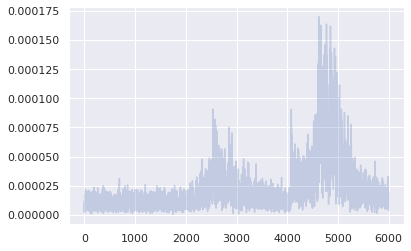

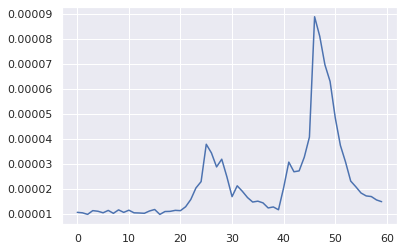

In [13]:
test_date = "2019-07-06.npy"
test_original = np.load(os.path.join(relevant_path, test_date))
test_compressed = np.load(os.path.join(compressed_path, test_date))

plt.plot(test_original[0, 0, :], alpha=0.25)
plt.show()
plt.plot(test_compressed[0, 0, :])
plt.show()

### Step-3: 
#### Approach 2: Subsample via max pooling

In [10]:
compressed_path = compressed_path_pool
if not os.path.exists(compressed_path):
    os.mkdir(compressed_path)
    
files = [entry.name for entry in os.scandir(relevant_path) if "2019" in entry.name]
print(files)
print(len(files))

WIDTH = 100
quake_counts = 0
for file in files:
    print("Processing file: {}".format(file))
    large = np.load(os.path.join(relevant_path, file))
    print("\tBefore: ", large.shape)
    comp_shape = (large.shape[0], large.shape[1], large.shape[2] // WIDTH)
    compressed = np.zeros(comp_shape)
    for i in range(comp_shape[2]):
        compressed[:, :, i] = np.max(large[:, :, WIDTH*i: WIDTH*(i+1)], 2)
    print("\tAfter: ", compressed.shape)
    quake_counts += large.shape[0]
    np.save(os.path.join(compressed_path, file), compressed)
    

['2019-06-12.npy', '2019-08-25.npy', '2019-07-31.npy', '2019-07-02.npy', '2019-07-07.npy', '2019-07-19.npy', '2019-07-17.npy', '2019-08-15.npy', '2019-08-04.npy', '2019-06-10.npy', '2019-08-10.npy', '2019-06-26.npy', '2019-09-30.npy', '2019-08-26.npy', '2019-09-13.npy', '2019-06-29.npy', '2019-08-13.npy', '2019-07-26.npy', '2019-07-21.npy', '2019-06-08.npy', '2019-07-15.npy', '2019-09-06.npy', '2019-09-11.npy', '2019-09-26.npy', '2019-06-04.npy', '2019-08-16.npy', '2019-07-18.npy', '2019-08-05.npy', '2019-07-08.npy', '2019-09-20.npy', '2019-08-12.npy', '2019-07-13.npy', '2019-09-16.npy', '2019-06-03.npy', '2019-06-30.npy', '2019-07-14.npy', '2019-07-22.npy', '2019-08-27.npy', '2019-07-25.npy', '2019-08-22.npy', '2019-06-19.npy', '2019-08-31.npy', '2019-08-11.npy', '2019-06-06.npy', '2019-06-27.npy', '2019-07-06.npy', '2019-06-07.npy', '2019-06-20.npy', '2019-08-24.npy', '2019-08-20.npy', '2019-09-23.npy', '2019-08-14.npy', '2019-06-16.npy', '2019-08-28.npy', '2019-09-29.npy', '2019-06-

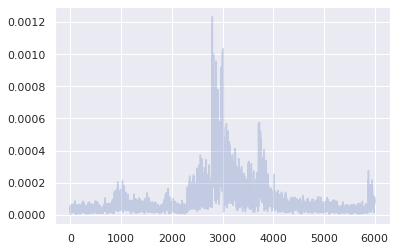

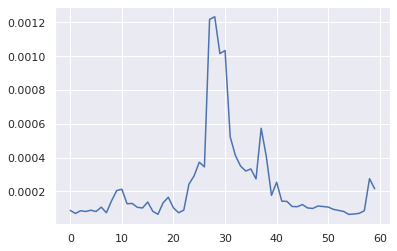

In [9]:
test_date = "2019-07-07.npy"
test_original = np.load(os.path.join(relevant_path, test_date))
test_compressed = np.load(os.path.join(compressed_path_pool, test_date))

plt.plot(test_original[0, 0, :], alpha=0.25)
plt.show()
plt.plot(test_compressed[0, 0, :])
plt.show()